# Compare hologram data with MERRA2 on Ozone

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date 2024-10-15
- last update 2024-10-16 (faint,bright, polar or not)
- last update 2024-10-17 with version v5
- last update 2024-10-18 : SupperImpose 2022,2023,2024
- last update : 2024-10-19 : Correct bugs on individual night curves
- Office emac : mamba_py311
- Home emac : base (conda)
- laptop : conda_py310

**Goal** : Show Night variations of Ozone wrt date and Time. Fit a straight line.

In [1]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [2]:
from platform import python_version
print(python_version())

3.11.5


In [3]:
import os

In [4]:
# where are stored the figures
pathfigs = "figsHoloMetta2Ozone"
if not os.path.exists(pathfigs):
    os.makedirs(pathfigs) 
figtype = ".png"

In [5]:
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor="white", alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants as c

from astropy.coordinates.earth import EarthLocation
from datetime import datetime
from pytz import timezone

from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit,least_squares


# new color correction model
import pickle
from scipy.interpolate import RegularGridInterpolator

In [6]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [7]:
# Remove this if want to run faster the ntoebook
#import ipywidgets as widgets
#%matplotlib widget

In [8]:
from importlib.metadata import version

In [9]:
# wavelength bin colors
#jet = plt.get_cmap('jet')
#cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [10]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

## Configuration

In [11]:
observing_location = EarthLocation.of_site('Rubin Observatory')
tz = timezone('America/Santiago')

### Spectro Hologram data

In [12]:
FLAG_WITHCOLLIMATOR = True
DATE_WITHCOLLIMATOR = 20230930
datetime_WITHCOLLIMATOR = convertNumToDatestr(DATE_WITHCOLLIMATOR)
datetime_WITHCOLLIMATOR = pd.to_datetime("2023-09-30 00:00:00.0+0000")
datetime_WITHCOLLIMATOR

Timestamp('2023-09-30 00:00:00+0000', tz='UTC')

In [13]:
version_results = "v5"
legendtag = {"v1" : "old v3.1.0",
            "v2" : "v3.1.0-PWV<10mm",
            "v3" : "v3.1.0-PWV<15mm",
            "v4" : "Auxtel holo v3.1.0",
            "v5" : "Auxtel holo v3.1.0 09/22 - 10/24"}

In [14]:
atmfilenamesdict = {"v1" : "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy",
                    "v2" : "auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_PeekFinder.npy",
                    "v3" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z.npy",
                    "v4" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z_spectrfullextend.npy",
                    "v5" : "u_dagoret_auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip_20241016T184601Z_spectrfullextended.npy"}

In [15]:
atmfilename = atmfilenamesdict[version_results]
tag = legendtag[version_results] 

### MERRA2

In [16]:
filename_m2 = "../SpectroMerra2/MerradataMerged/Merge_inst1_2d_asm_Nx_M2I1NXASM-2021-2024.csv"

In [17]:
df_m = pd.read_csv(filename_m2)

## Initialisation

### Read the file

In [18]:
specdata = np.load(atmfilename,allow_pickle=True)

In [19]:
df_spec = pd.DataFrame(specdata)

### Define if a target is faint or bright

In [20]:
def IsFaint(row):
    List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
    List_Of_faint_selected = List_Of_Faint_targets[:10]
    if row["TARGET"] in List_Of_faint_selected:
        return True
    else:
        return False

In [21]:
df_spec["isFaint"] = df_spec.apply(IsFaint,axis=1)

### Compute NightObs

In [22]:
df_spec["nightObs"] = df_spec.apply(lambda x: x['id']//100_000, axis=1)

In [23]:
if FLAG_WITHCOLLIMATOR:
    df_spec = df_spec[df_spec["nightObs"]> DATE_WITHCOLLIMATOR]

## Apply Quality selection

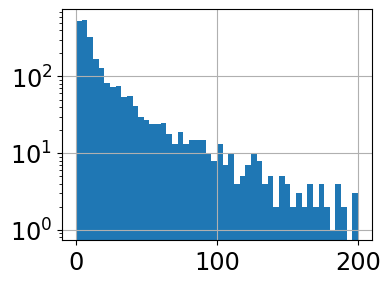

In [24]:
fig,ax = plt.subplots(1,1)
df_spec["CHI2_FIT"].hist(bins=50,ax=ax,range=(0,200))
ax.set_yscale("log")

### Add the Time in pd.datetime

#### UTC

In [25]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])

In [26]:
DT = pd.Timedelta(minutes=7*24*60)
TMIN  = df_spec["Time"].min()-DT
TMAX  = df_spec["Time"].max()+DT

### Compute relative time to Mid-night

In [27]:
def GetTimeToMidNight(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(local_time.year,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
    local_time_midnight = datetime(local_time_new.year,local_time_new.month,local_time_new.day)
    dt_hour = (local_time_new -local_time_midnight).seconds/3600.

    # we took the previous night mid-night , must subtract 24H
    if dt_hour > 12.:
        dt_hour_new = (dt_hour - 24.)
    else:
        dt_hour_new = dt_hour
        
    return dt_hour_new

In [28]:
df_spec["dt_midnight"] = df_spec.apply(GetTimeToMidNight,axis=1)

<Axes: >

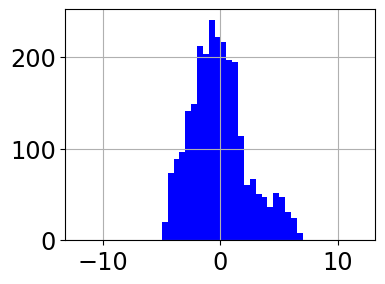

In [29]:
df_spec["dt_midnight"].hist(bins=48,range=(-12,12),facecolor="b") 

### Compute Date relative to January

In [30]:
def GetDateToMidJanuary(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
    
          
    return pd.to_datetime(local_time_new)

In [31]:
#df_spec["Time_january"] = df_spec.apply(GetDateToMidJanuary,axis=1)

In [32]:
def GetDateToMidJanuaryAndYear(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
           
    return pd.to_datetime(local_time_new),local_time.year 

In [33]:
df_spec[["Time_january","Year"]] = df_spec.apply(GetDateToMidJanuaryAndYear,axis=1,result_type="expand")

In [34]:
df_spec[["Time_january","Year"]]

Time_january  Year
3329 2024-10-10 23:02:25  2023
3330 2024-10-10 23:03:38  2023
3331 2024-10-10 23:25:46  2023
3332 2024-10-10 23:26:59  2023
3333 2024-10-10 23:34:11  2023
...                  ...   ...
5914 2024-10-16 05:33:33  2024
5915 2024-10-16 05:41:00  2024
5916 2024-10-16 05:42:13  2024
5917 2024-10-16 05:49:45  2024
5918 2024-10-16 05:50:58  2024

[2590 rows x 2 columns]

## Compute night boundaries

In [35]:
def GetNightBoundariesDict(df_spec):
    """
    input:
      df_spec the dataframe for spectroscopy summary results
    output:
      the dict of night boudaries
    """
    
    Dt = pd.Timedelta(minutes=30)
    d = {}
    list_of_nightobs = df_spec["nightObs"].unique()
    for nightobs in list_of_nightobs:
        sel_flag = df_spec["nightObs"]== nightobs
        df_night = df_spec[sel_flag]
        tmin = df_night["Time"].min()-Dt
        tmax = df_night["Time"].max()+Dt
        d[nightobs] = (tmin,tmax)
    return d

In [36]:
dn = GetNightBoundariesDict(df_spec)

## Plot all data

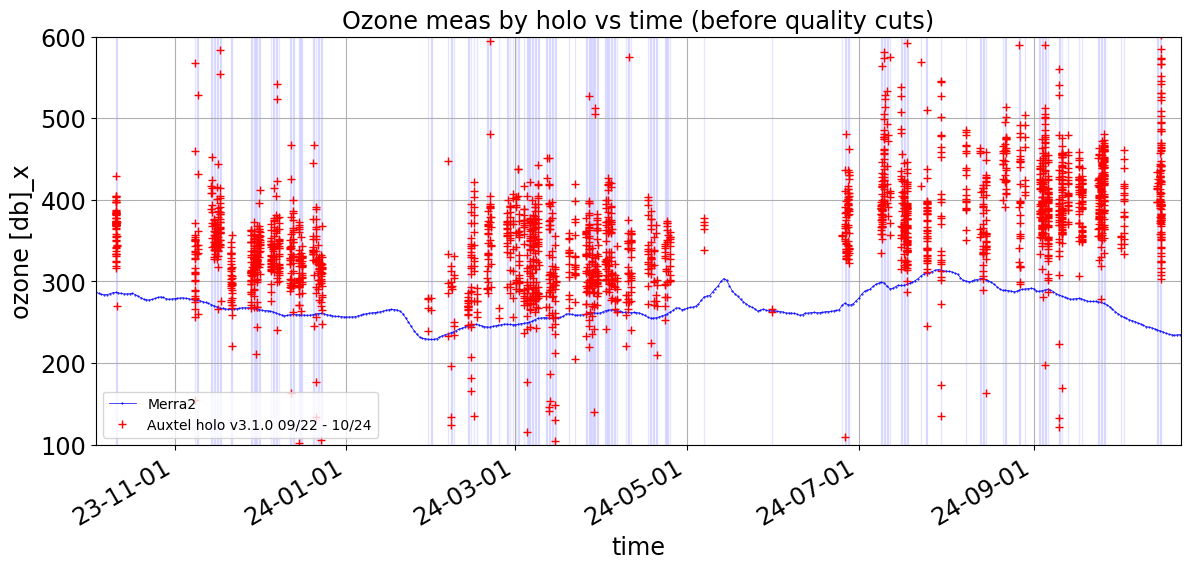

In [37]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax  = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TO3",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df_spec.plot(x="Time",y="ozone [db]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("ozone [db]_x")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Ozone meas by holo vs time (before quality cuts)")
ax.legend()
ax.set_ylim(100.,600.)

for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)

ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

figname =f"{pathfigs}/ozone_allpoints_allnights_nocuts"+figtype
plt.savefig(figname)
plt.show()

## Apply Quality selection cuts

In [38]:
def getSelectionCut_old(df_spec, chi2max=20., o3min=1.0, o3max = 599.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["ozone [db]_x"] > o3min) & (df_spec["ozone [db]_x"] < o3max) 
    return cut

In [39]:
def getSelectionCut(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) 
    return cut

In [40]:
def getSelectionCutNoPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] != "HD185975")
    return cut

In [41]:
def getSelectionCutWithPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] == "HD185975")
    return cut

In [42]:
cut = getSelectionCut(df_spec) 
cut_nopolar_bright = getSelectionCutNoPolar(df_spec) & (~df_spec["isFaint"])
cut_nopolar_faint = getSelectionCutNoPolar(df_spec) & (df_spec["isFaint"])
cut_wthpolar = getSelectionCutWithPolar(df_spec)
cut_nopolar = getSelectionCutNoPolar(df_spec)

In [43]:
df_spec_sel = df_spec[cut]
df_spec_np_b = df_spec[cut_nopolar_bright]
df_spec_np_f = df_spec[cut_nopolar_faint]
df_spec_wp = df_spec[cut_wthpolar]
df_spec_np = df_spec[cut_nopolar] 

In [44]:
print("Total number of Spectra          : ",len(df_spec))
print("Number of selected Spectra       : ",len(df_spec_sel))
print("Number of selected Polars        : ",len(df_spec_wp))
print("Number of selected Non-Polars    : ",len(df_spec_np))
print("Number of selected Non-Polars Bright : ",len(df_spec_np_b))
print("Number of selected Non-Polars Faint  : ",len(df_spec_np_f))

Total number of Spectra          :  2590
Number of selected Spectra       :  1057
Number of selected Polars        :  489
Number of selected Non-Polars    :  568
Number of selected Non-Polars Bright :  484
Number of selected Non-Polars Faint  :  84


In [45]:
df_spec_sel.reset_index(drop=True,inplace=True)
df_spec_np_b.reset_index(drop=True,inplace=True)
df_spec_np_f.reset_index(drop=True,inplace=True)
df_spec_wp.reset_index(drop=True,inplace=True) 
df_spec_np.reset_index(drop=True,inplace=True)

In [46]:
#List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
print("Polar            :",len(df_spec_wp["TARGET"].unique()),"\t", df_spec_wp["TARGET"].unique()) 
print("Non Polar        :",len(df_spec_np["TARGET"].unique()),"\t" ,df_spec_np["TARGET"].unique())
print("Non Polar Bright :",len(df_spec_np_b["TARGET"].unique()),"\t" ,df_spec_np_b["TARGET"].unique())
print("Non Polar Faint  :",len(df_spec_np_f["TARGET"].unique()),"\t",df_spec_np_f["TARGET"].unique())

Polar            : 1 	 ['HD185975']
Non Polar        : 6 	 ['HD205905' 'HD2811' 'HD38666' 'HD111980' 'HD146233' 'HD160617']
Non Polar Bright : 4 	 ['HD205905' 'HD2811' 'HD38666' 'HD146233']
Non Polar Faint  : 2 	 ['HD111980' 'HD160617']


## Recompute night boundaries

In [47]:
#dn = GetNightBoundariesDict(df_spec_sel)

## Plot all data

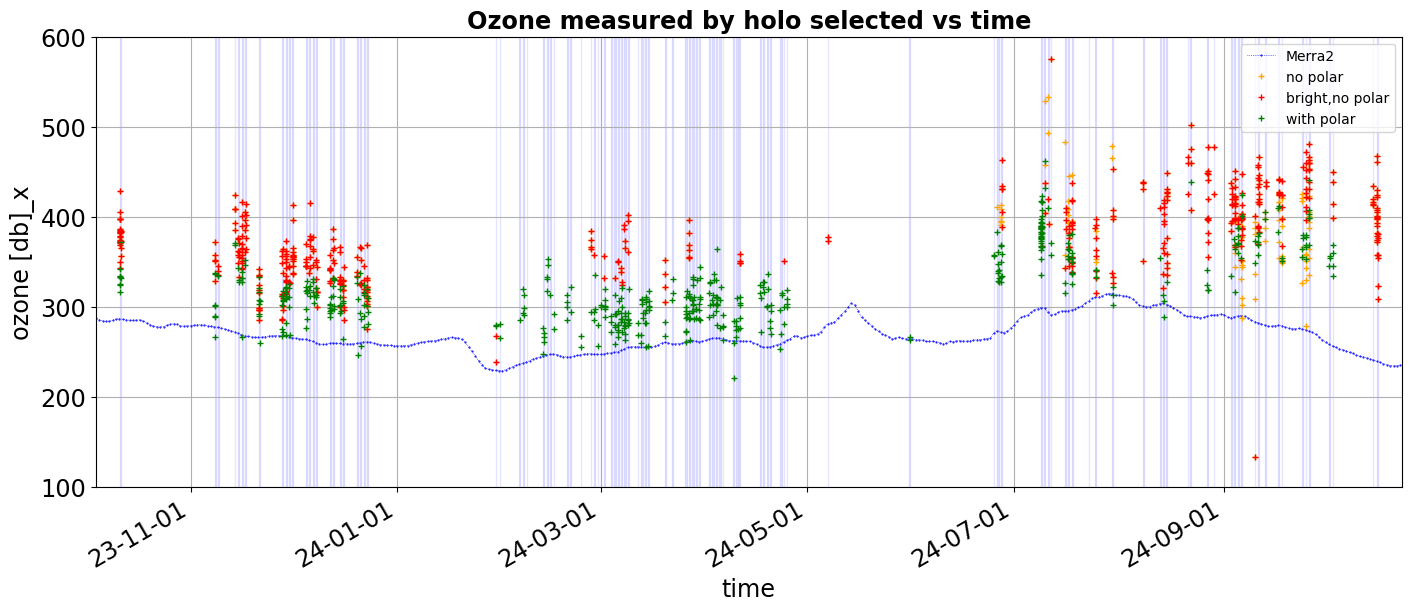

In [48]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TO3",ax=ax,marker=".",c="b",lw=0.5,ls=":",label="Merra2",ms=1,legend=leg)     

#df_spec_sel.plot(x="Time",y="ozone [db]_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label=tag,legend=leg,ms=5,alpha=0.2)
#df_spec_np_f.plot(x="Time",y="ozone [db]_x",ax=ax,marker='o',c="grey",lw=0.0,grid=True,label="faint, no polar",legend=leg,ms=5,alpha=0.2)

df_spec_np.plot(x="Time",y="ozone [db]_x",ax=ax,marker='+',c="orange",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=1)
df_spec_np_b.plot(x="Time",y="ozone [db]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg,ms=5,alpha=1)
df_spec_wp.plot(x="Time",y="ozone [db]_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=1)
ax.set_ylabel("ozone [db]_x")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Ozone measured by holo selected vs time",fontweight="bold")
ax.legend(loc="upper right")
ax.set_ylim(100.,600.)

for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


figname =f"{pathfigs}/ozone_allpoints_allnights_wthcuts"+figtype
plt.savefig(figname)
plt.show()

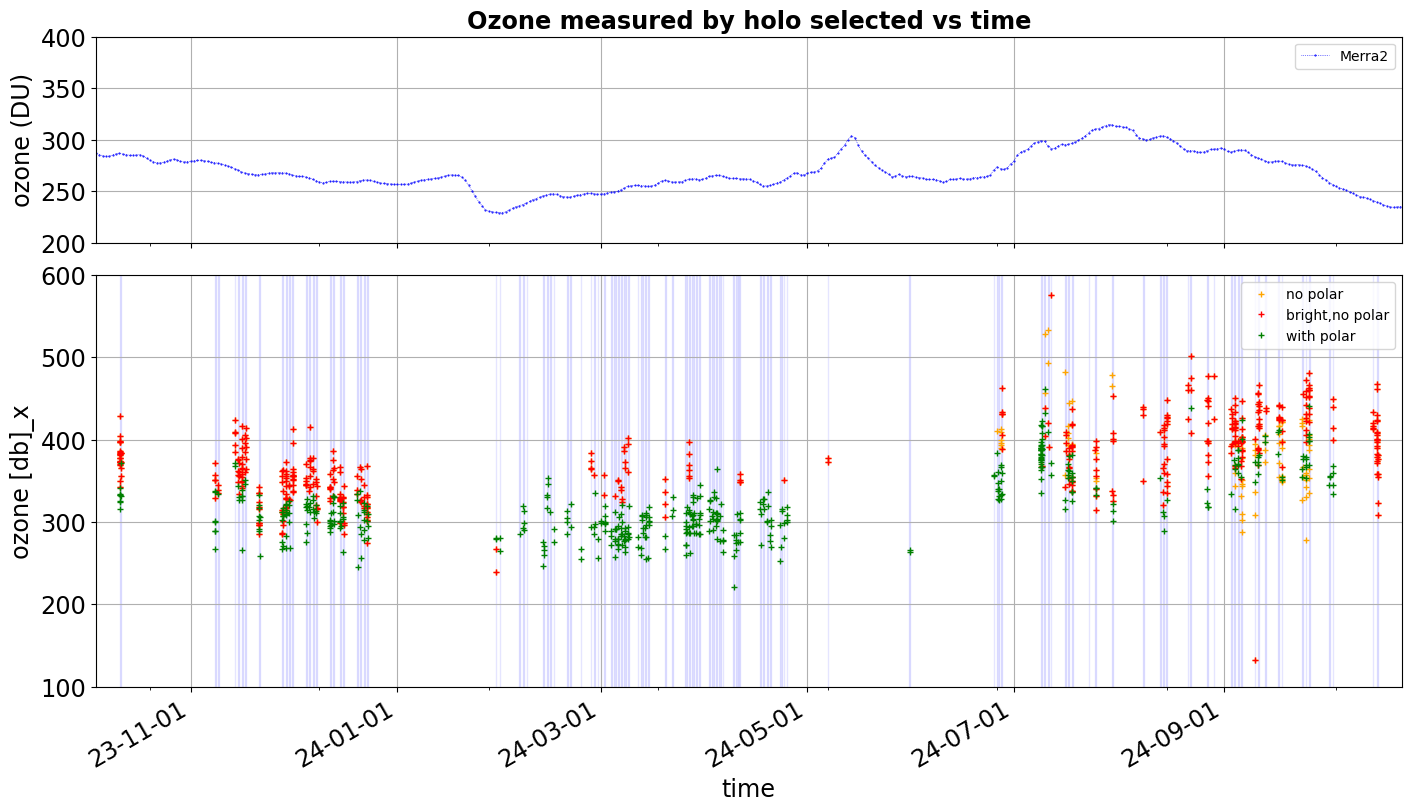

In [49]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")

fig = plt.figure(figsize=(14,8),layout='constrained')
gs = GridSpec(2, 1,  height_ratios=[1,2],figure=fig)

# left figure
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax)

leg=ax.get_legend()
leg2=ax2.get_legend()

# top
ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TO3",ax=ax,marker=".",c="b",lw=0.5,ls=":",grid=True,label="Merra2",ms=1,legend=leg)     
ax.set_ylabel("ozone (DU)")
ax.set_ylim(200.,400.)
ax.legend()

#bottom
df_spec_np.plot(x="Time",y="ozone [db]_x",ax=ax2,marker='+',c="orange",lw=0.0,grid=True,label="no polar",legend=leg2,ms=5,alpha=1)
df_spec_np_b.plot(x="Time",y="ozone [db]_x",ax=ax2,marker='+',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg2,ms=5,alpha=1)
df_spec_wp.plot(x="Time",y="ozone [db]_x",ax=ax2,marker='+',c="g",lw=0.0,grid=True,label="with polar",legend=leg2,ms=5,alpha=1)
ax2.set_ylabel("ozone [db]_x")

ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)
ax.set_title("Ozone measured by holo selected vs time",fontweight="bold")
ax2.legend(loc="upper right")
ax2.set_ylim(100.,600.)
for key, tt in dn.items():
    ax2.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


ax2.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


figname =f"{pathfigs}/ozone_allpoints_allnights_wthcuts_separatemeera"+figtype
plt.savefig(figname)
plt.show()

Text(0, 0.5, 'Ozone (DU)')

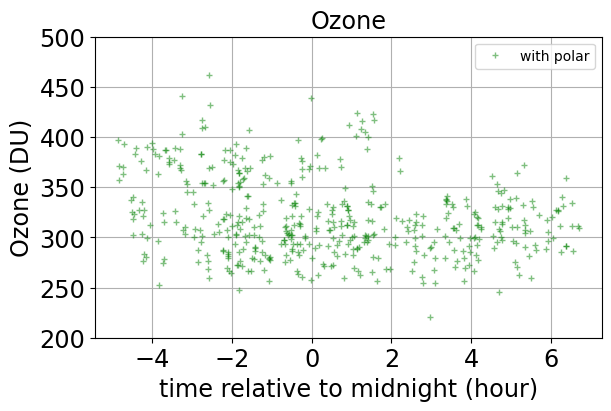

In [50]:
fig,axs = plt.subplots(1,1,figsize=(6,4),layout='constrained')
ax  = axs
leg=ax.get_legend()
df_spec_wp.plot(x="dt_midnight",y="ozone [db]_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=0.5)
ax.set_ylim(200.,500.)
ax.legend()
ax.set_xlabel("time relative to midnight (hour)")
ax.set_title("Ozone")
ax.set_ylabel("Ozone (DU)")

Text(0, 0.5, 'Ozone_y (DU)')

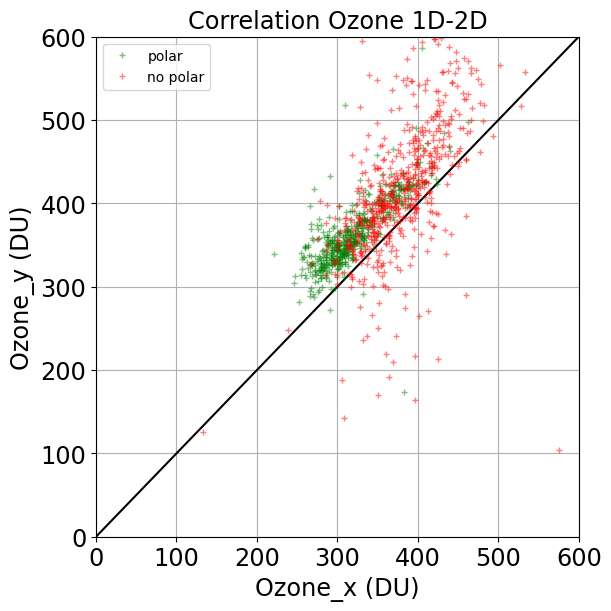

In [51]:
fig,axs = plt.subplots(1,1,figsize=(6,6),layout='constrained')
ax  = axs
leg=ax.get_legend()
ax.plot([0.,600.],[0.,600.],"k-")
df_spec_wp.plot(x="ozone [db]_x",y="ozone [db]_y",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="polar",legend=leg,ms=5,alpha=0.5)
df_spec_np.plot(x="ozone [db]_x",y="ozone [db]_y",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)
ax.set_ylim(0.,600.)
ax.set_xlim(0.,600.)

ax.legend()
ax.set_xlabel("Ozone_x (DU)")
ax.set_title("Correlation Ozone 1D-2D")
ax.set_ylabel("Ozone_y (DU)")

In [52]:
list(df_spec_wp.columns)

['DATE-OBS',
 'id',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'EXTEND',
 'TARGET',
 'REDSHIFT',
 'GRATING',
 'ROTANGLE',
 'D2CCD',
 'LSHIFT',
 'DOMEAZ',
 'AZ',
 'EL',
 'RA',
 'MJD',
 'WINDSPD',
 'WINDDIR',
 'PARANGLE',
 'TARGETX',
 'TARGETY',
 'LBDA_REF',
 'PSF_REG',
 'TRACE_R',
 'MEANFWHM',
 'PIXSHIFT',
 'CHI2_FIT',
 'A2_FIT',
 'AM_FIT',
 'VERSION',
 'CCD_REBIN',
 'CONFIG',
 'EXPTIME',
 'AIRMASS',
 'DEC',
 'HA',
 'OUTTEMP',
 'OUTPRESS',
 'OUTHUM',
 'FILTER',
 'CAM_ROT',
 'S_X0',
 'S_Y0',
 'S_XMIN',
 'S_XMAX',
 'S_YMIN',
 'S_YMAX',
 'S_NX',
 'S_NY',
 'S_DEG',
 'S_SAT',
 'S_ORDER',
 'A1_x',
 'A1_err_x',
 'A2_x',
 'A2_err_x',
 'A3',
 'A3_err',
 'VAOD_x',
 'VAOD_err_x',
 'angstrom_exp_x',
 'angstrom_exp_err_x',
 'ozone [db]_x',
 'ozone [db]_err_x',
 'PWV [mm]_x',
 'PWV [mm]_err_x',
 'B_x',
 'B_err_x',
 'A_star',
 'A_star_err',
 'D_CCD [mm]_x',
 'D_CCD [mm]_err_x',
 'shift_x [pix]',
 'shift_x [pix]_err',
 'shift_y [pix]',
 'shift_y [pix]_err',
 'angle [deg]',
 'angle [deg]_err',
 'P [hPa

(200.0, 500.0)

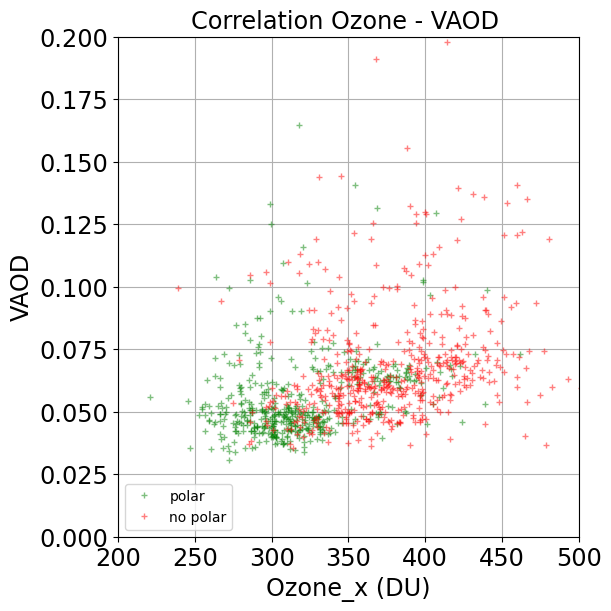

In [53]:
fig,axs = plt.subplots(1,1,figsize=(6,6),layout='constrained')
ax  = axs
leg=ax.get_legend()
df_spec_wp.plot(x="ozone [db]_x",y="VAOD_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="polar",legend=leg,ms=5,alpha=0.5)
df_spec_np.plot(x="ozone [db]_x",y="VAOD_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)

ax.legend()
ax.set_xlabel("Ozone_x (DU)")
ax.set_title("Correlation Ozone - VAOD ")
ax.set_ylabel("VAOD")
ax.set_ylim(0.,0.2)
ax.set_xlim(200.,500.)

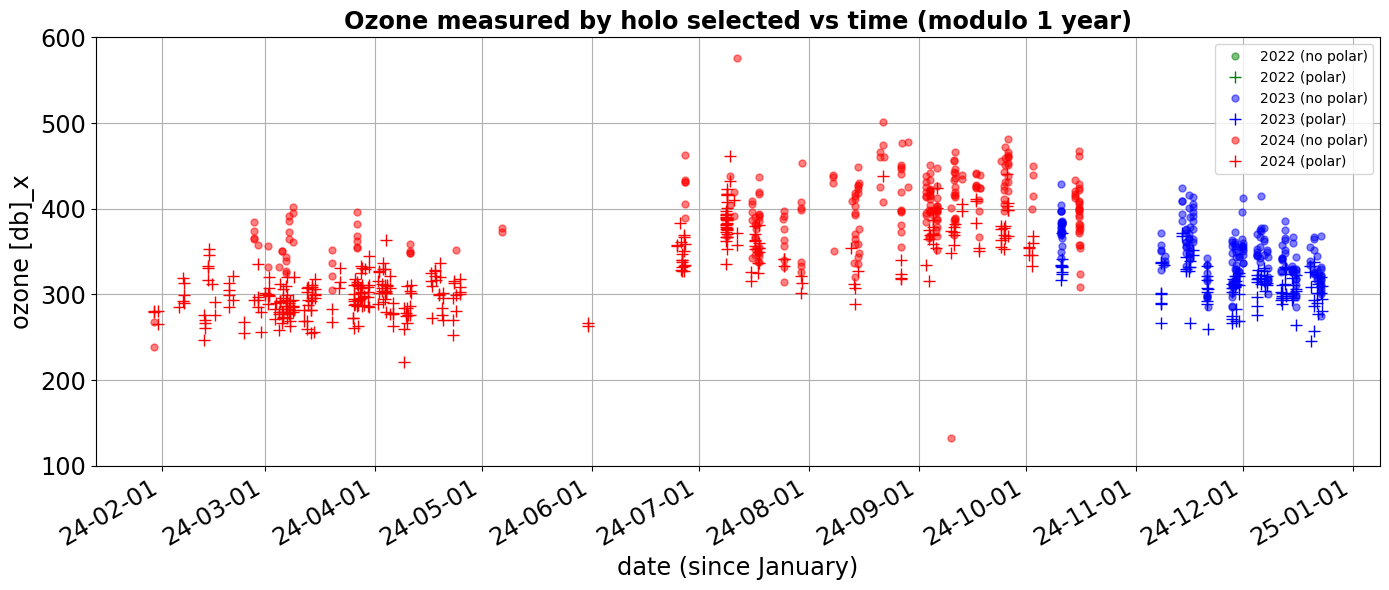

In [54]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")

fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()


df_spec_np_b[df_spec_np_b.Year == 2022].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="2022 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2022].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="2022 (polar)",legend=leg,ms=8,alpha=1)

df_spec_np_b[df_spec_np_b.Year == 2023].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='o',c="b",lw=0.0,grid=True,label="2023 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2023].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='+',c="b",lw=0.0,grid=True,label="2023 (polar)",legend=leg,ms=8,alpha=1)

df_spec_np_b[df_spec_np_b.Year == 2024].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="2024 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2024].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="2024 (polar)",legend=leg,ms=8,alpha=1)





ax.set_ylabel("ozone [db]_x")
ax.set_xlabel("date (since January)")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Ozone measured by holo selected vs time (modulo 1 year)",fontweight="bold")
ax.legend(loc="upper right")

#for key, tt in dn.items():
#    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


#ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


plt.tight_layout()
 


ax.set_ylim(100.,600.)
#ax.set_xlim(TMIN,TMAX)

figname =f"{pathfigs}/ozoneholoM2_allpoints_allnights_modulo1year"+figtype
plt.savefig(figname)
plt.show()

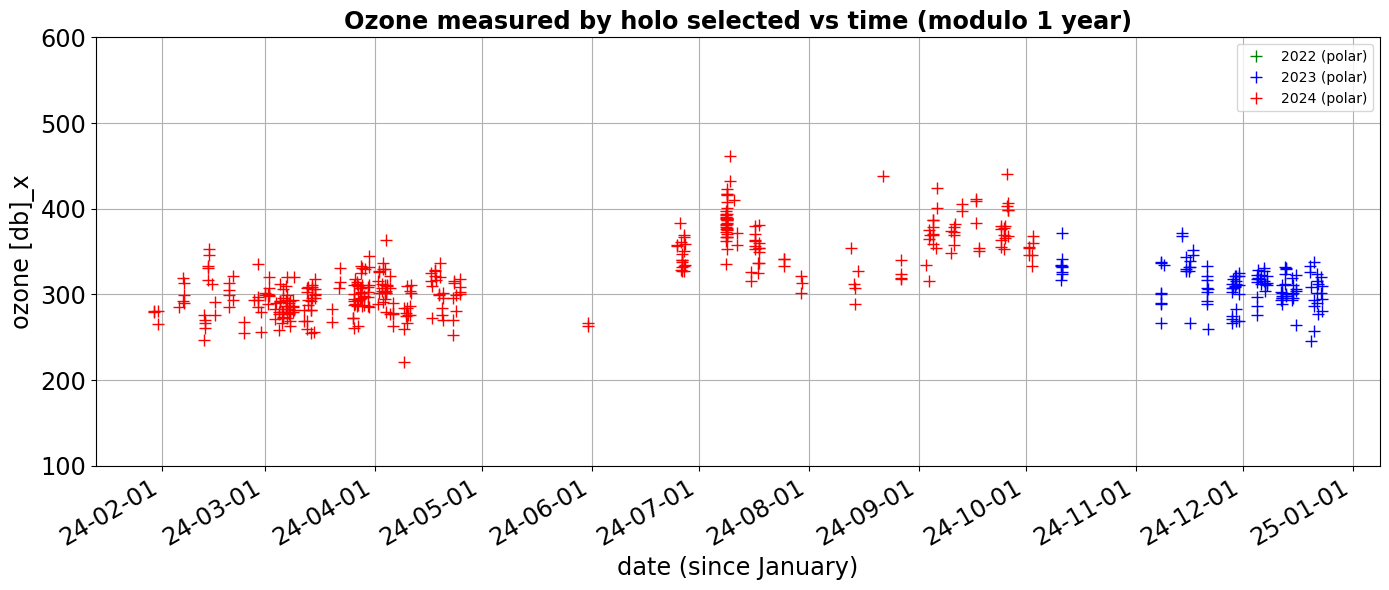

In [55]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")

fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()


#df_spec_np_b[df_spec_np_b.Year == 2022].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="2022 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2022].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="2022 (polar)",legend=leg,ms=8,alpha=1)

#df_spec_np_b[df_spec_np_b.Year == 2023].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='o',c="b",lw=0.0,grid=True,label="2023 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2023].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='+',c="b",lw=0.0,grid=True,label="2023 (polar)",legend=leg,ms=8,alpha=1)

#df_spec_np_b[df_spec_np_b.Year == 2024].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="2024 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2024].plot(x="Time_january",y="ozone [db]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="2024 (polar)",legend=leg,ms=8,alpha=1)


ax.set_ylabel("ozone [db]_x")
ax.set_xlabel("date (since January)")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Ozone measured by holo selected vs time (modulo 1 year)",fontweight="bold")
ax.legend(loc="upper right")

#for key, tt in dn.items():
#    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)

#ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

plt.tight_layout()
 
ax.set_ylim(100.,600.)
#ax.set_xlim(TMIN,TMAX)

figname =f"{pathfigs}/ozoneholoM2_allpoints_allnights_wp_modulo1year"+figtype
plt.savefig(figname)
plt.show()

## Show time variation each night

In [56]:
all_selected_nights = df_spec_sel["nightObs"].unique()

In [57]:
def funclineres(params, x, y, yerr):
    # Return residual = fit-observed
    return (y-params[0] -params[1]*x)/yerr
def funcline(params,x):
    return params[0] + params[1]*x

In [58]:
def MakeLineFit(df_night_pwv_curve):
    """
    """

    x = df_night_pwv_curve["dt_midnight"].values
    y = df_night_pwv_curve["ozone [db]_x"].values
    yerr = df_night_pwv_curve["ozone [db]_err_x"].values
    n = len(y)
        
    #popt, pcov = optimize.curve_fit(f, x, y, [1,-4])
    fit_res = least_squares(funclineres,[5.,0],args = (x,y,yerr))
    popt = fit_res.x 
    npar = len(popt)
    J = fit_res.jac
    cov = np.linalg.inv(J.T.dot(J))
    chi2dof = ((funclineres(popt,x,y,yerr))**2).sum()/(n-npar)
    cov *= chi2dof
    perr = np.sqrt(np.diagonal(cov)) 
    
    xfit = np.linspace(x.min()*0.99,x.max()*1.05)
    yfit = funcline(popt,xfit)
        
    slope = popt[1]
    slope_err = perr[1]

    return x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err

### Plot night by night

In [59]:
def ComputeRepeatability(df):
    """
    Compute Repeatability of Ozone for Spectrogram and and Spectrum
    
    """
    N = len(df)
    dfout = pd.DataFrame(index=df.index,columns = ["nightObs","dt","dt_rep","dOZx_rep","dOZy_rep","targflag_rep","Npoints"])
    dfout["targflag_rep"].astype(bool)
    #dfout["Npoints"].astype(int)
    
    target_old = "No"
    time_old = 0.
    OZx_old = 0.
    OZy_old = 0.
    
    for index in range(N):
        
        nightObs =  df.iloc[index]["nightObs"]
        
        if index ==0:
            dt0 = df.iloc[index]["dt"]
            dfout.iloc[index] = [ nightObs,dt0, 0., 0., 0., False,N]
        else:
            target_new = df.iloc[index]["TARGET"]
            time_new = df.iloc[index]["dt"]
            OZx_new = df.iloc[index]["ozone [db]_x"]
            OZy_new = df.iloc[index]["ozone [db]_y"]
            
            flag_target = (target_new == target_old)
            dOZx_rep = OZx_new - OZx_old
            dOZy_rep = OZy_new - OZy_old
            dt_rep = (time_new-time_old)*3600. # in seconds
            
            dfout.iloc[index] = [ nightObs,time_new, dt_rep, dOZx_rep, dOZy_rep, flag_target,N]
        
        target_old = df.iloc[index]["TARGET"]
        time_old = df.iloc[index]["dt"]
        OZx_old = df.iloc[index]["ozone [db]_x"]
        OZy_old = df.iloc[index]["ozone [db]_y"]
        
    return dfout

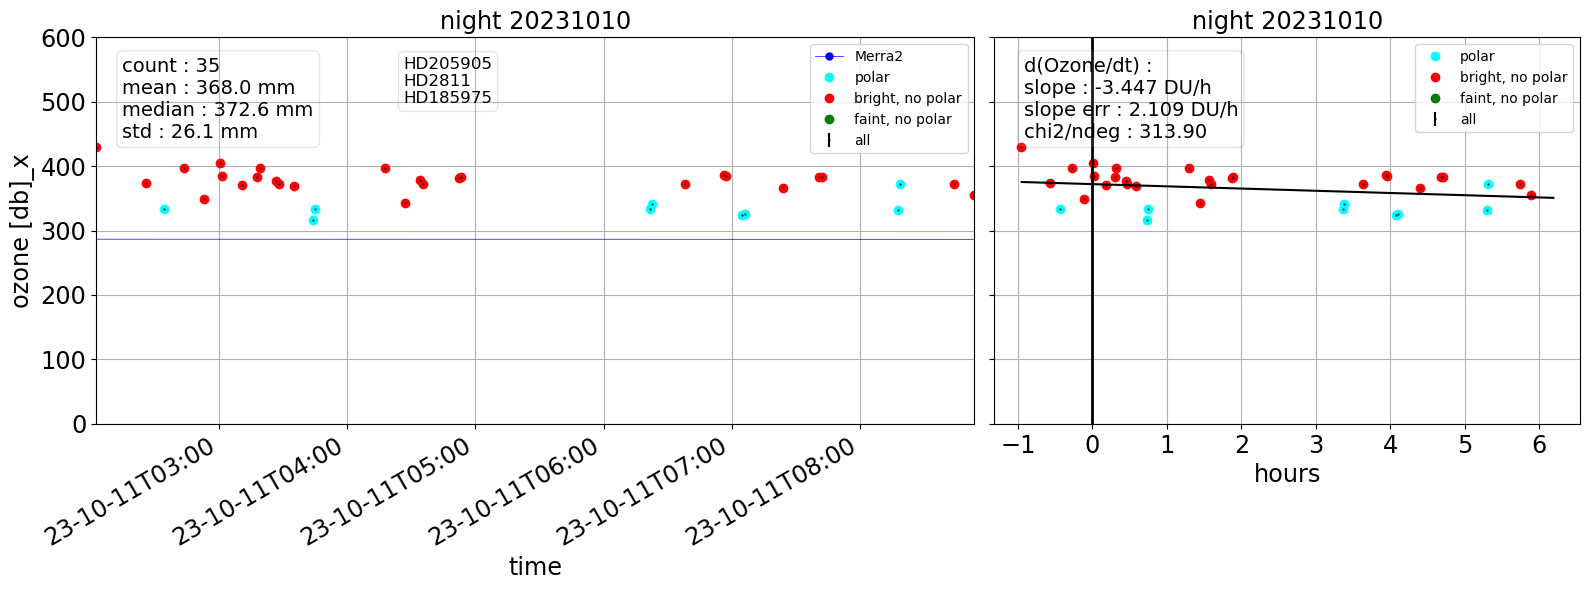

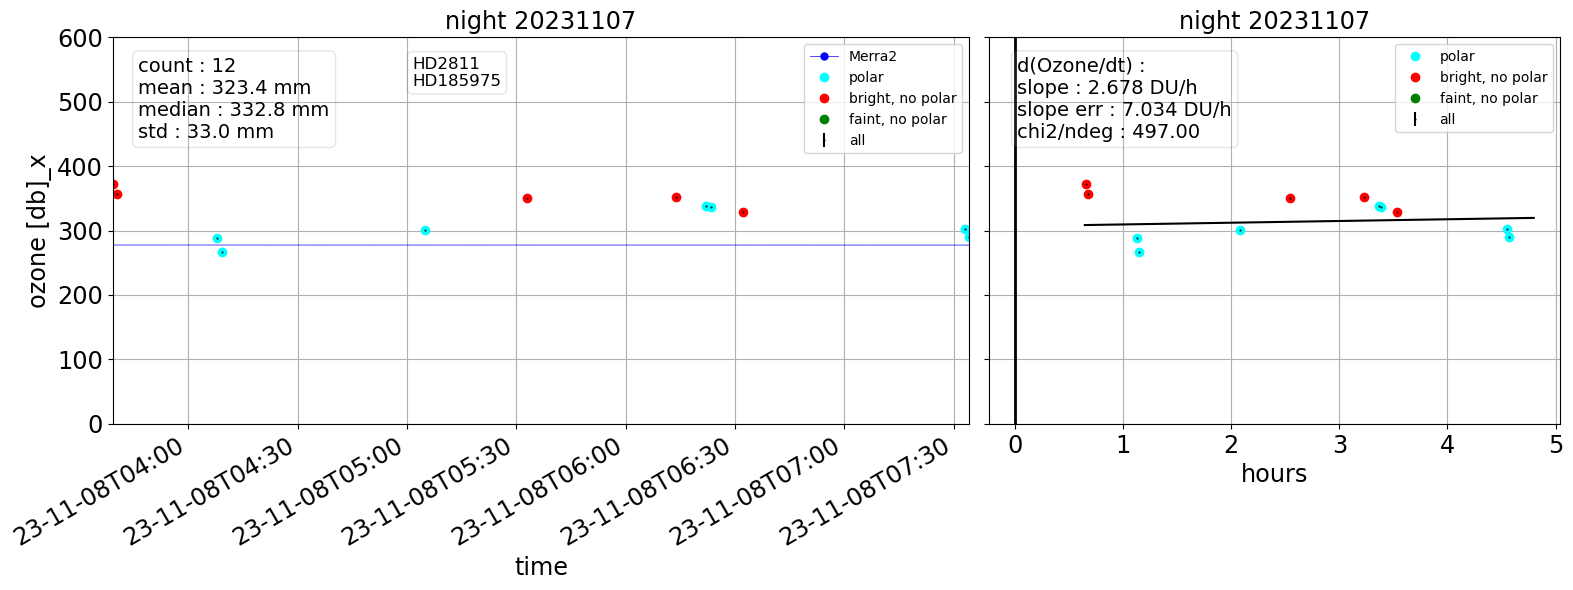

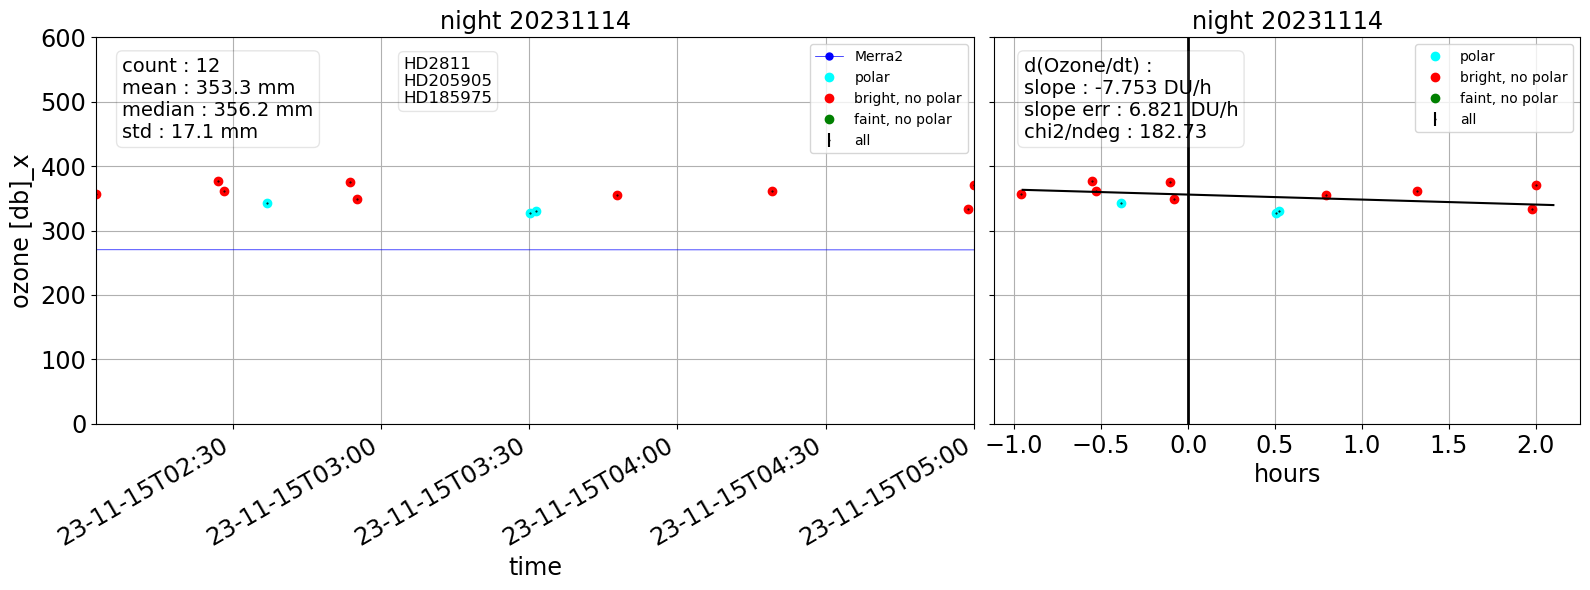

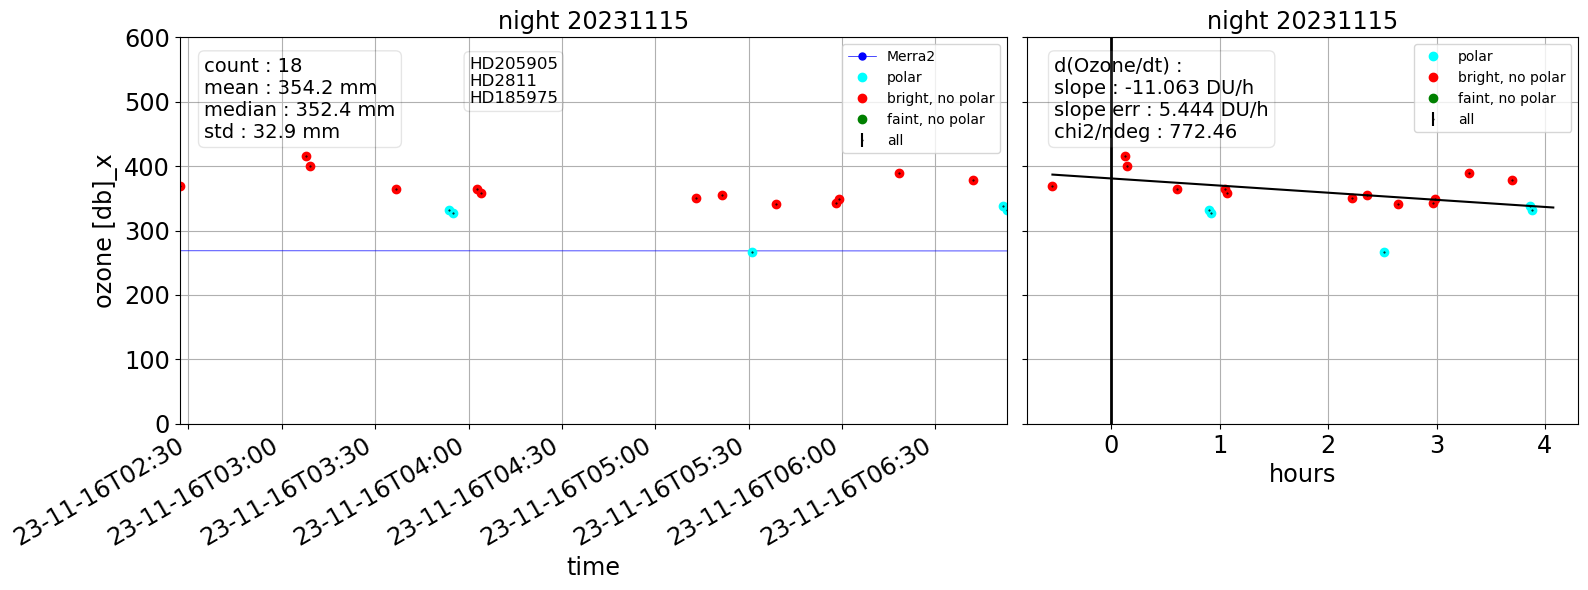

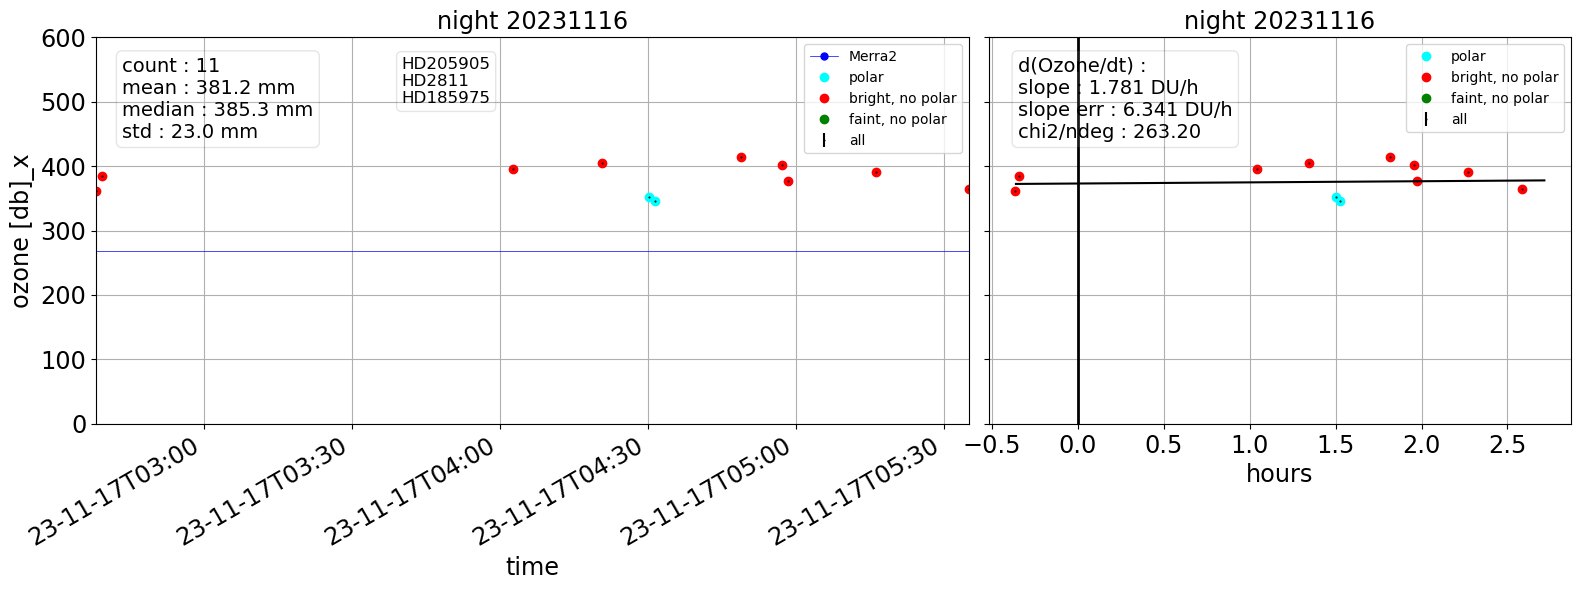

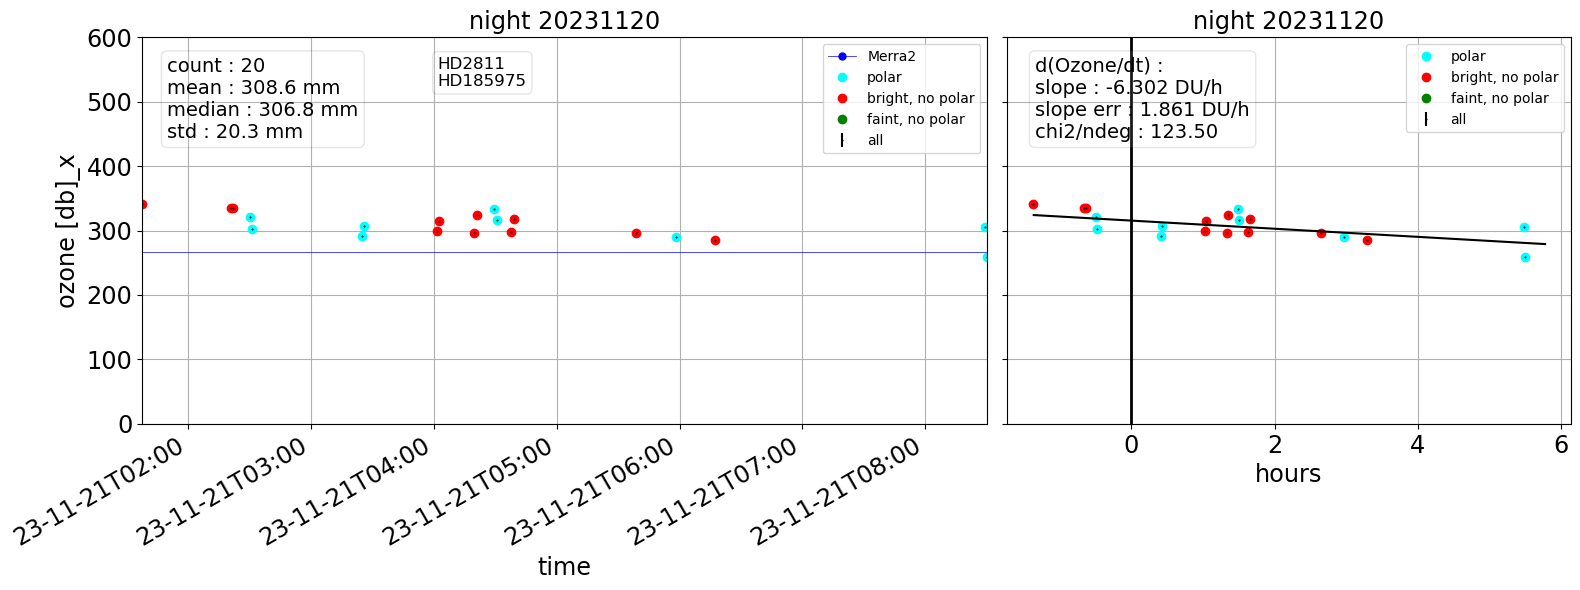

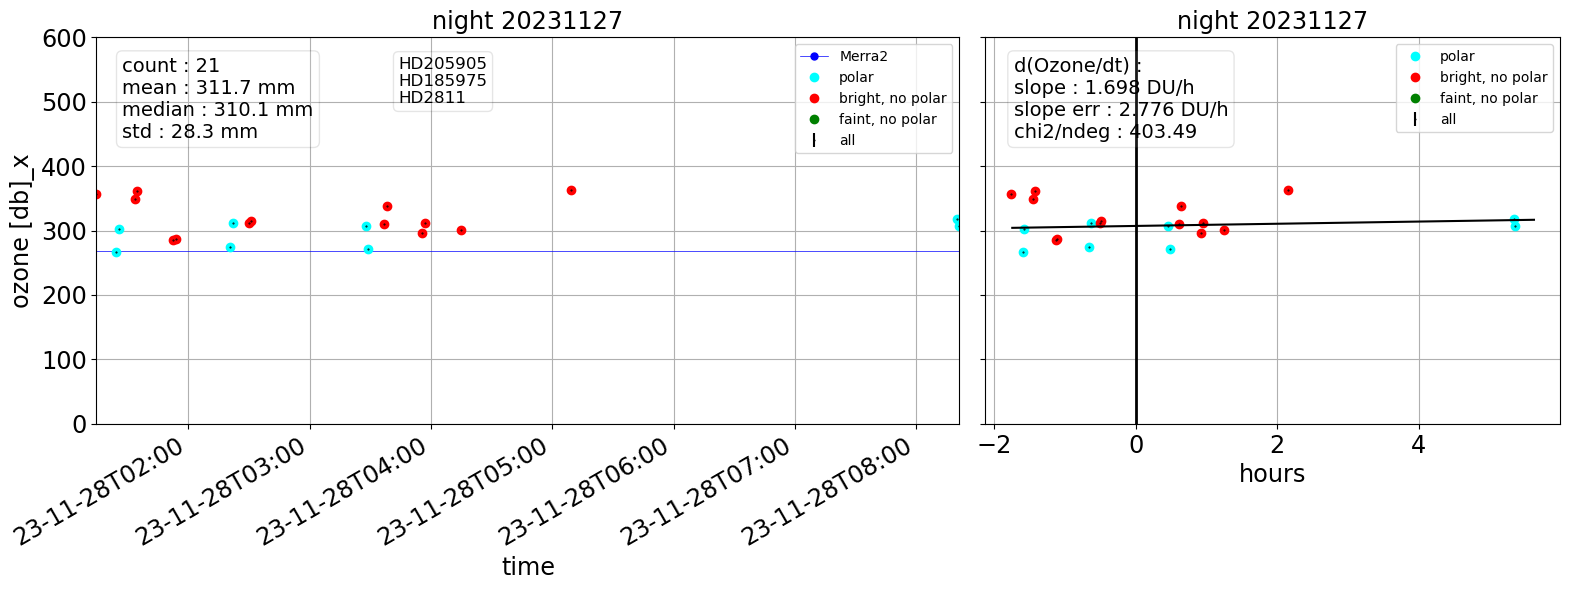

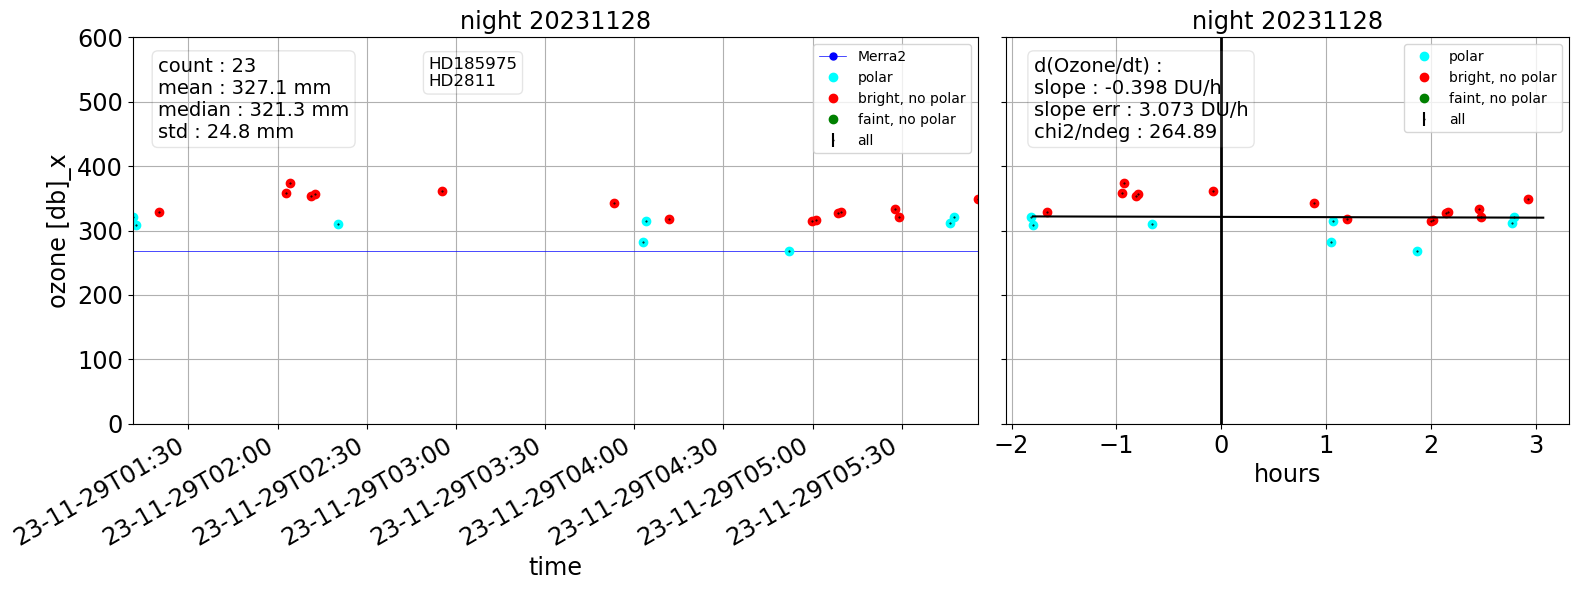

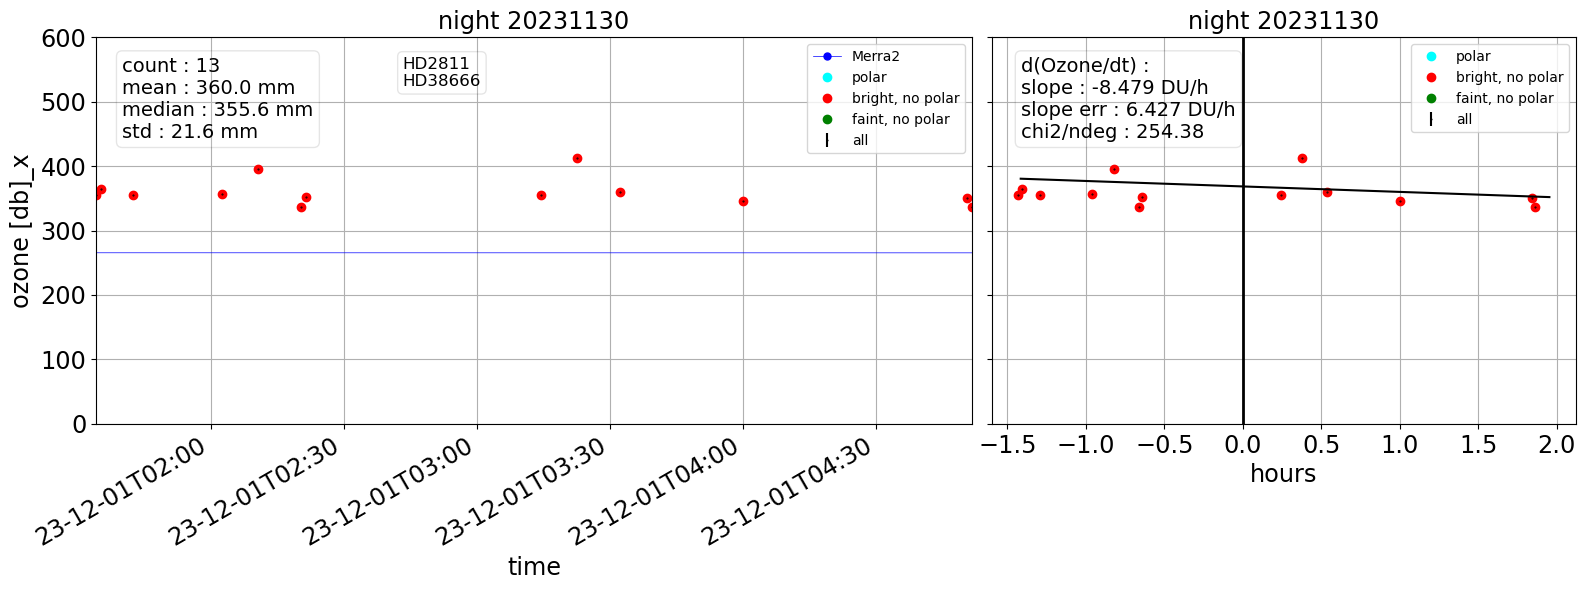

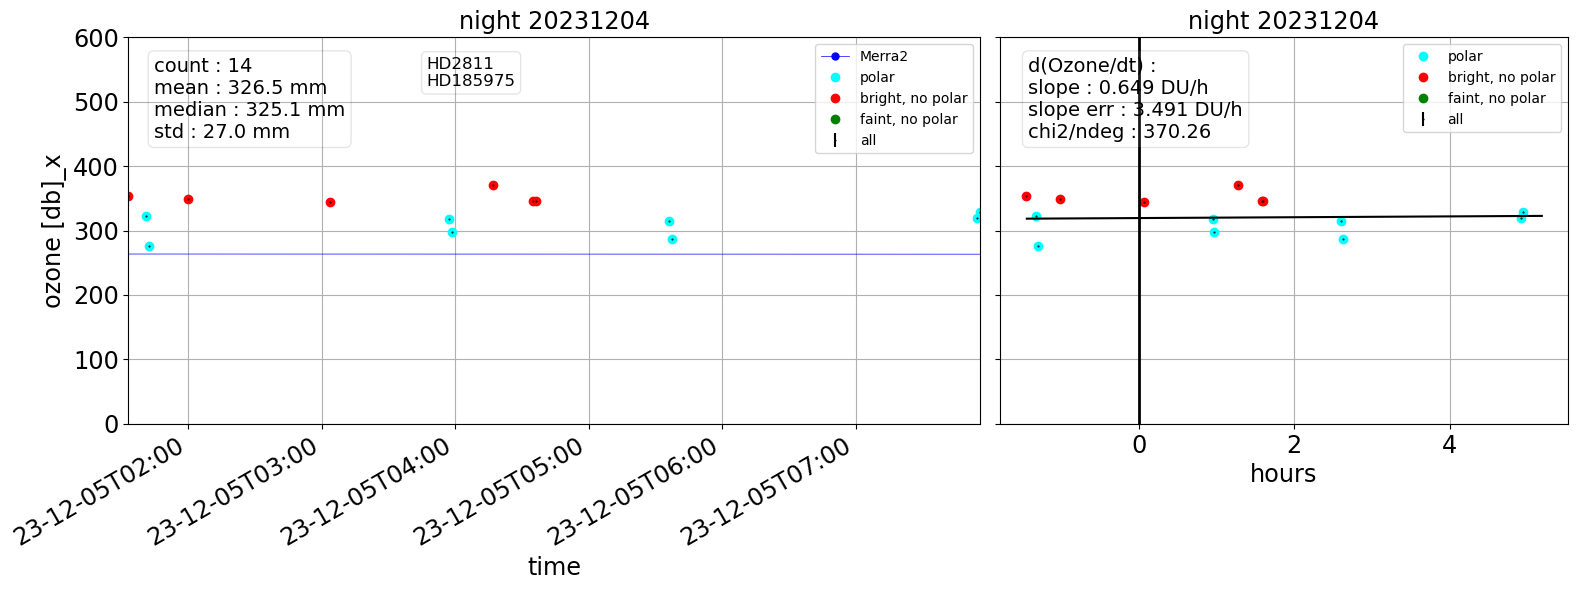

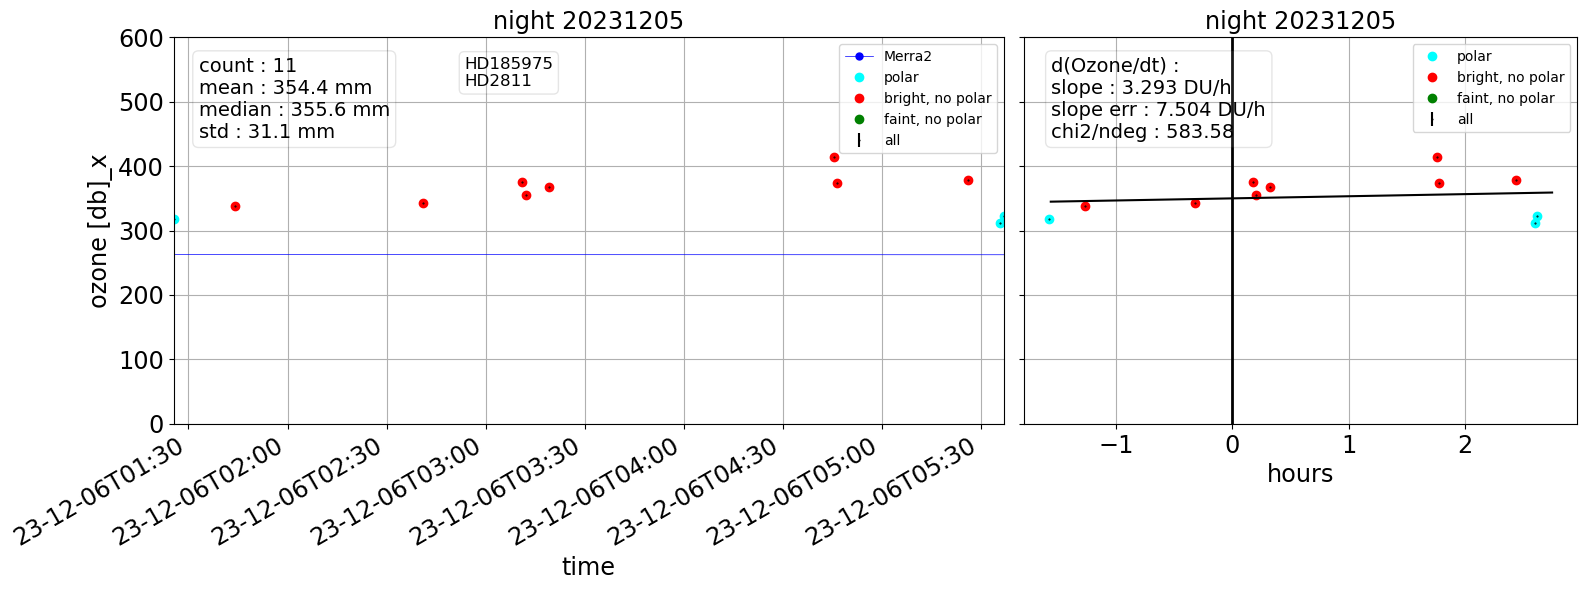

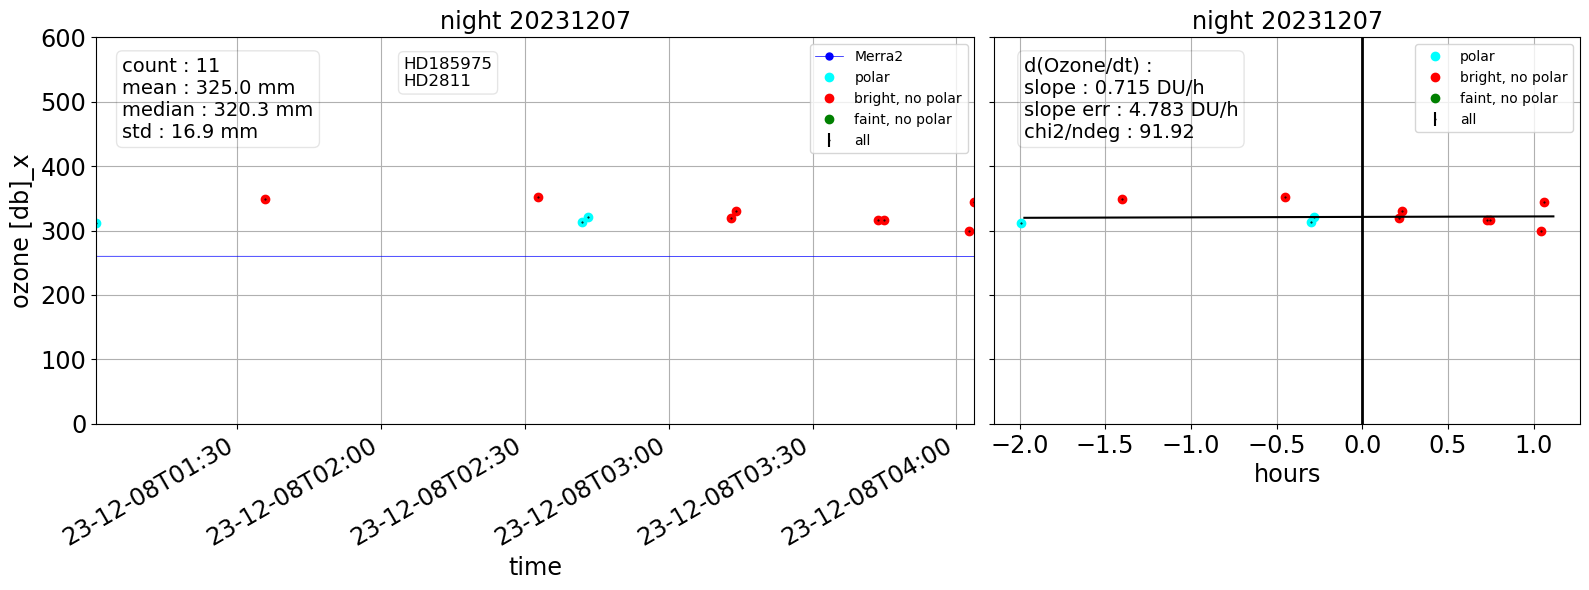

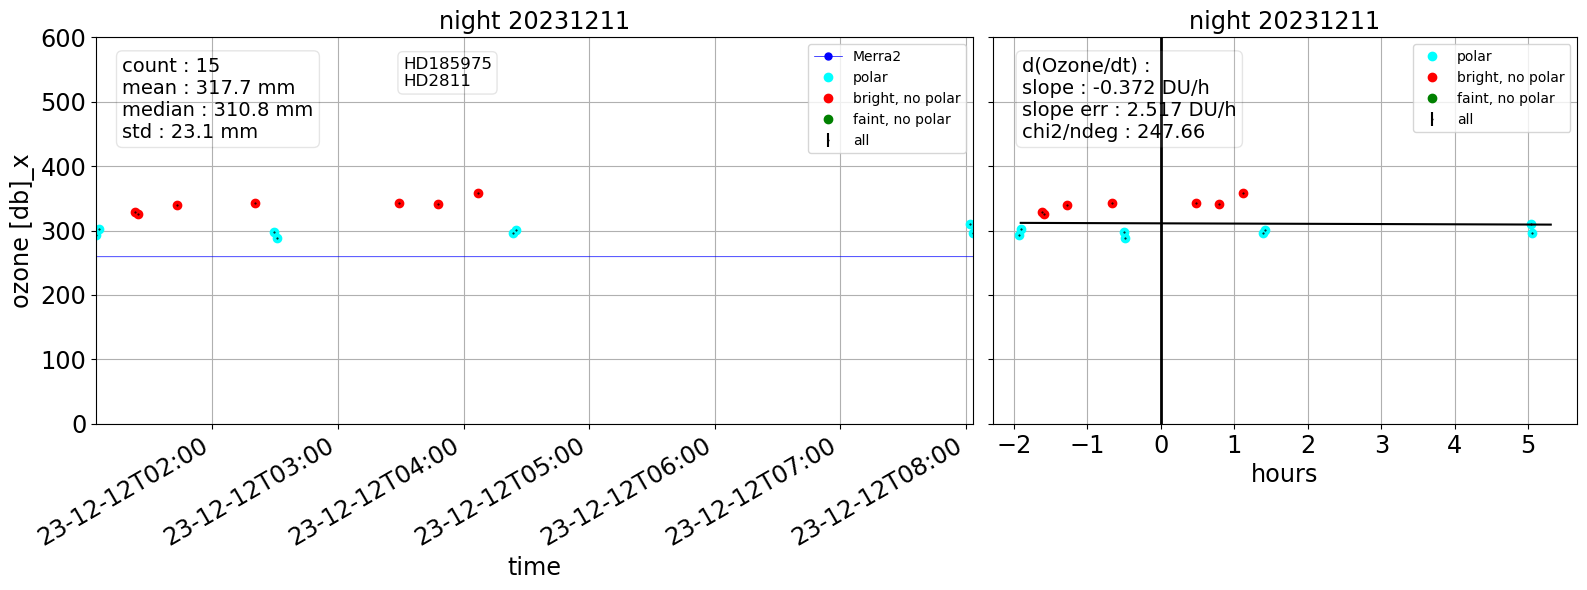

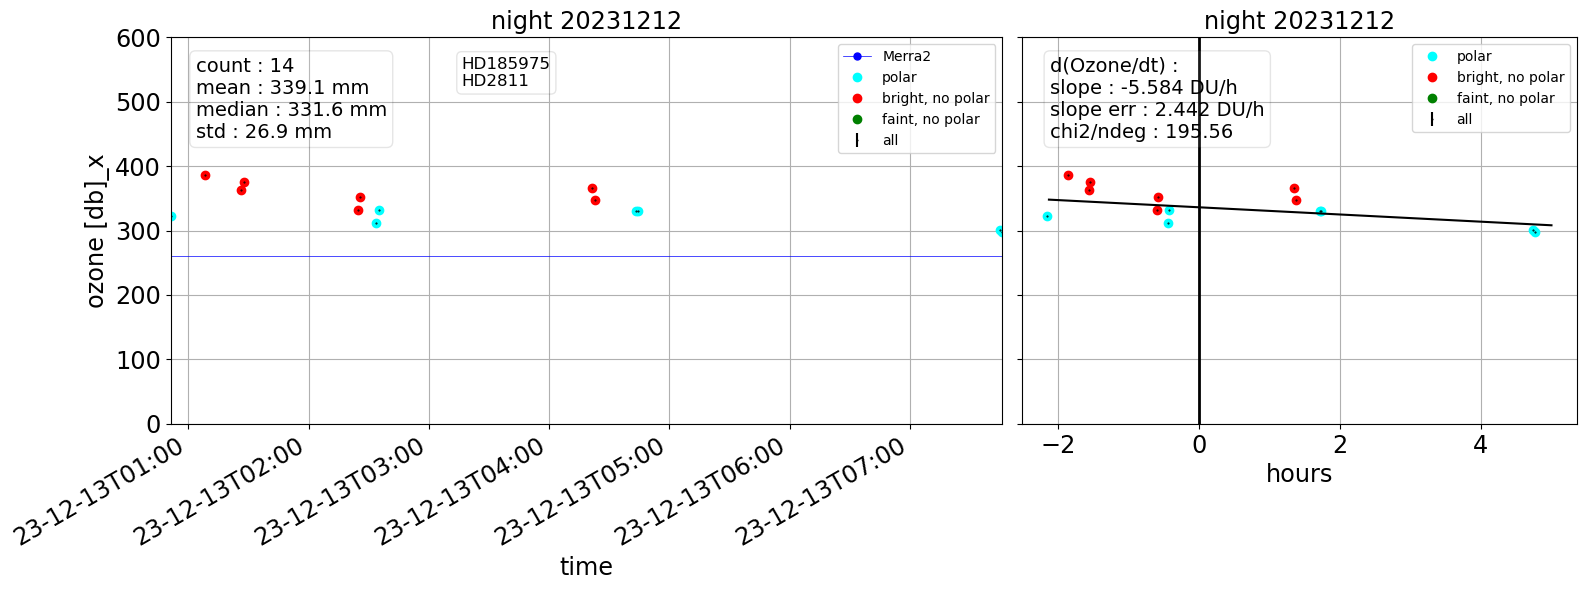

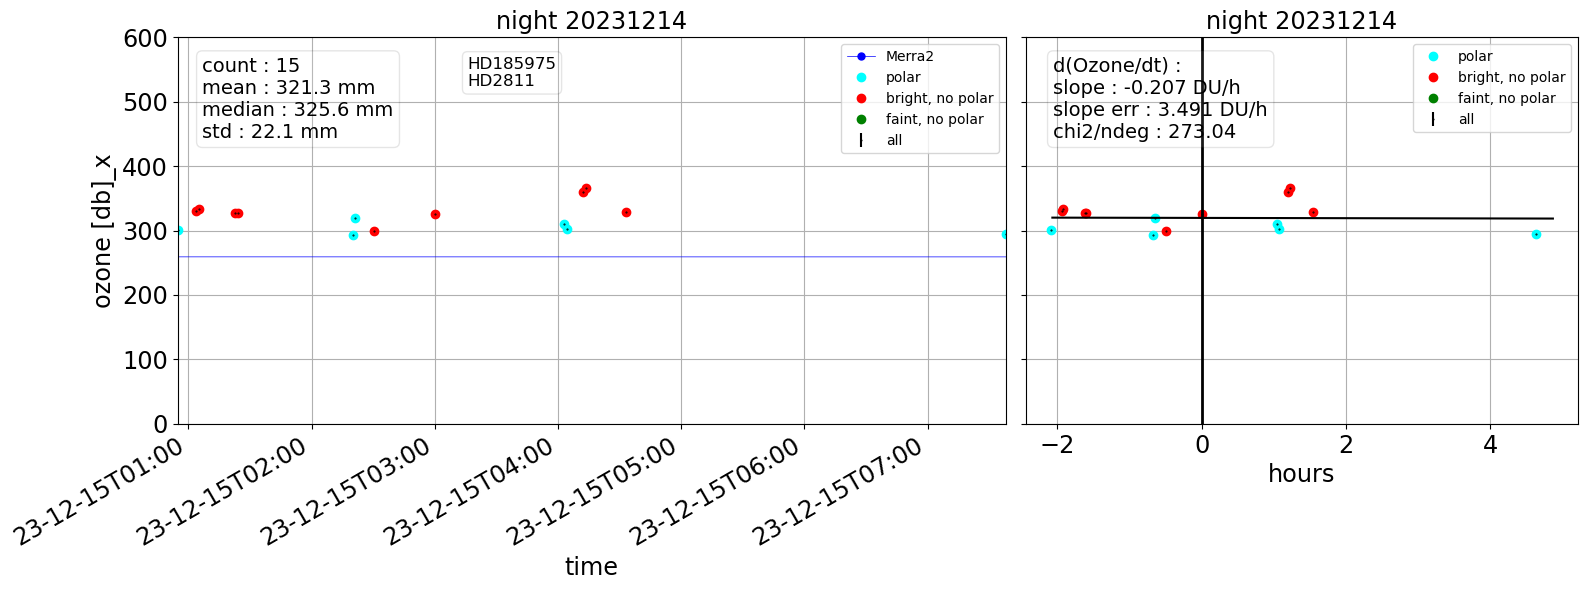

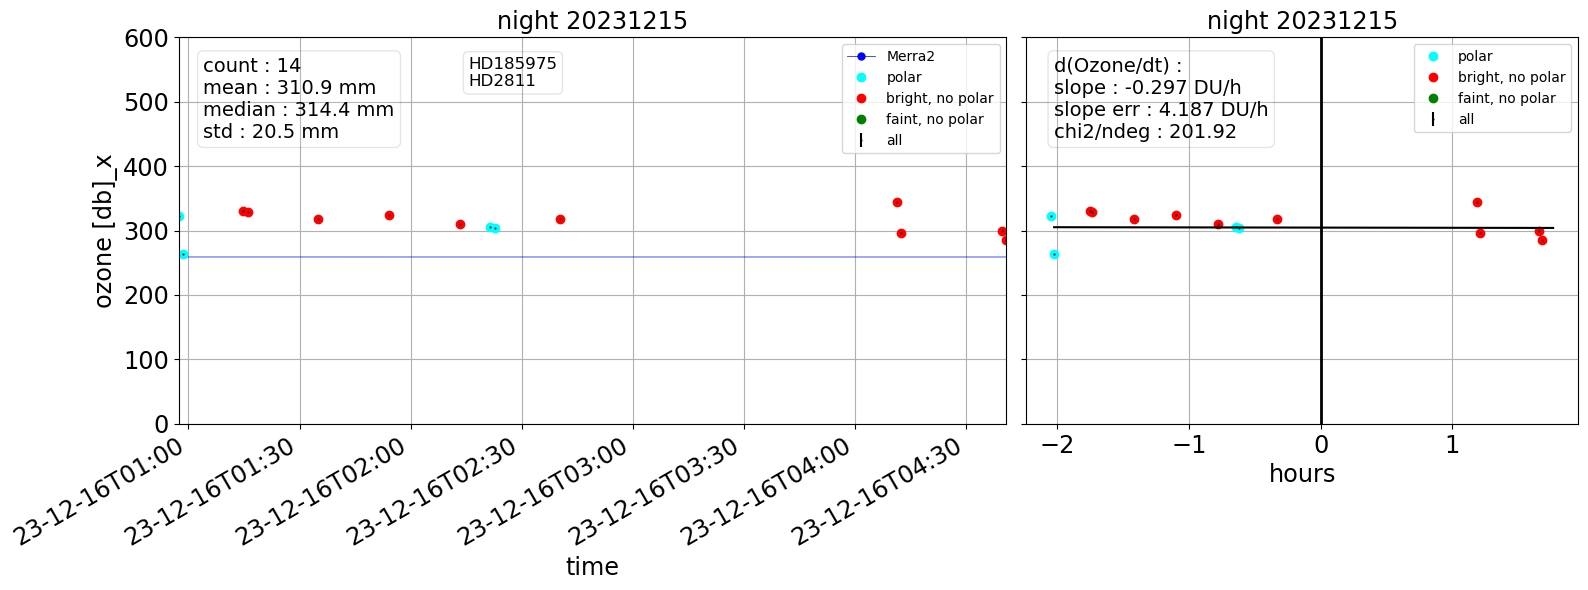

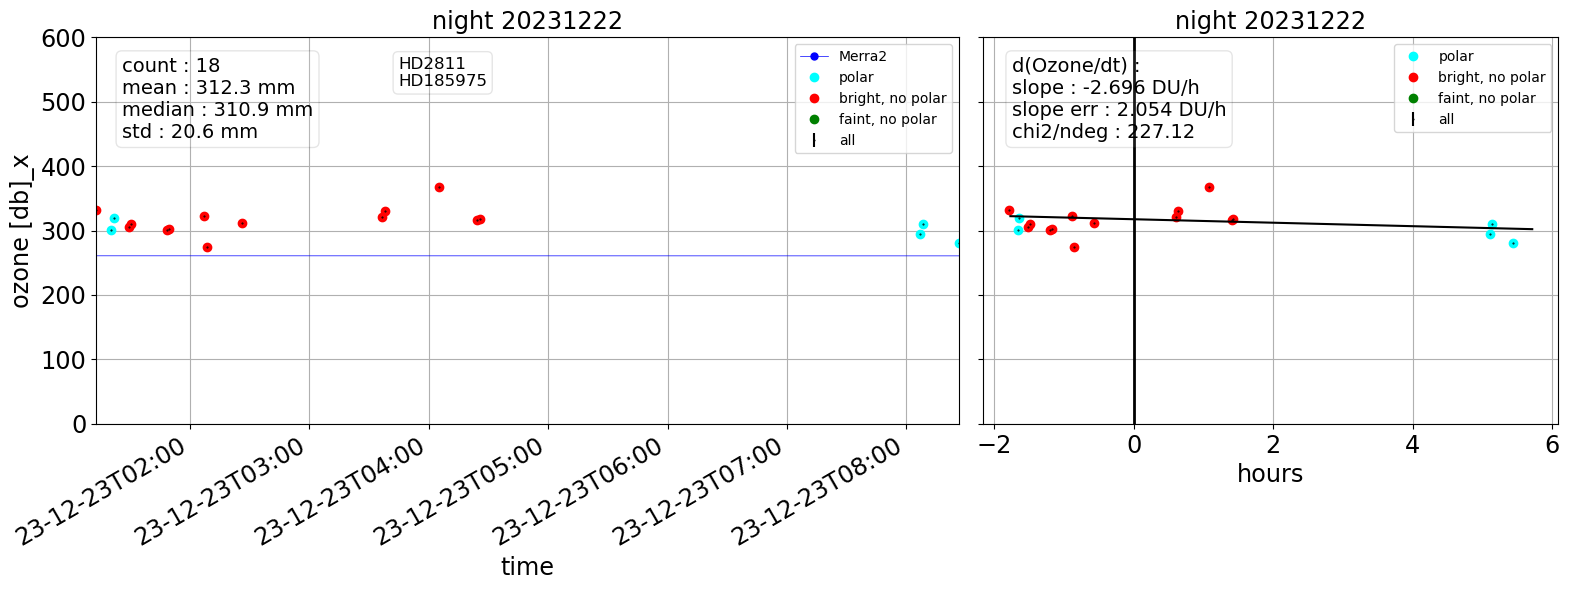

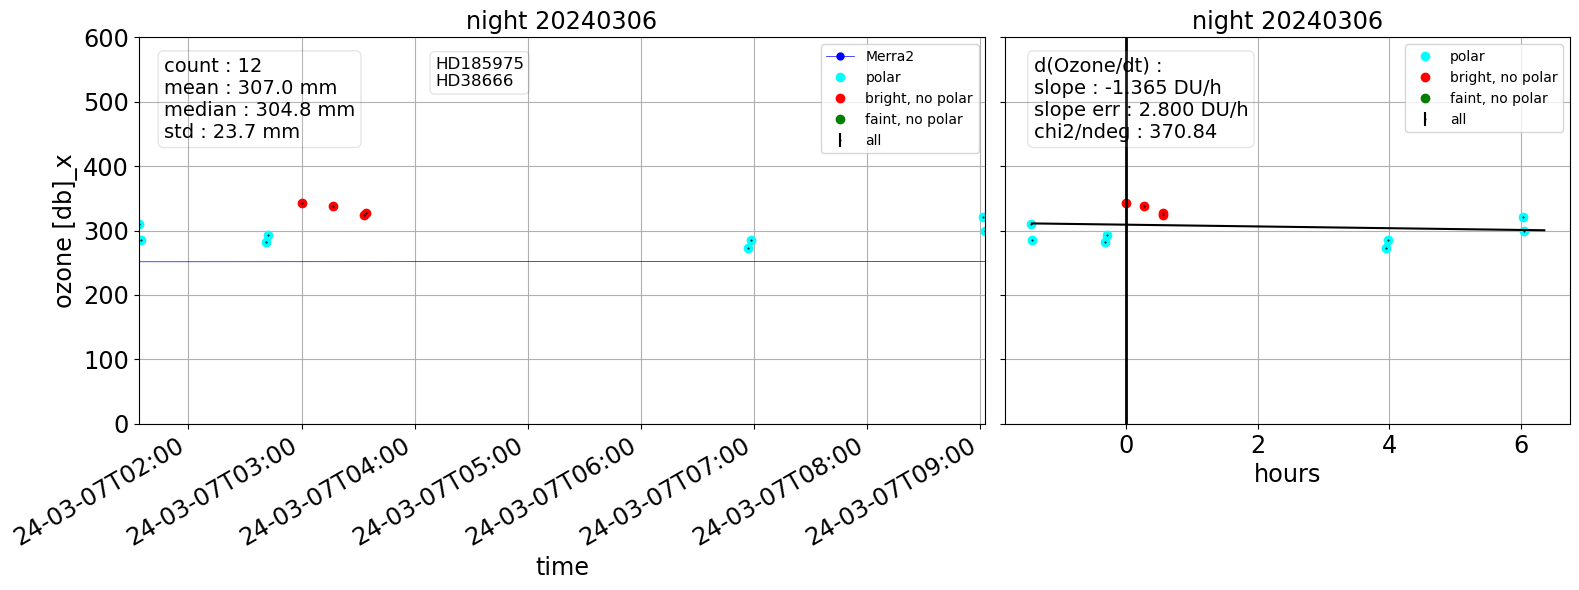

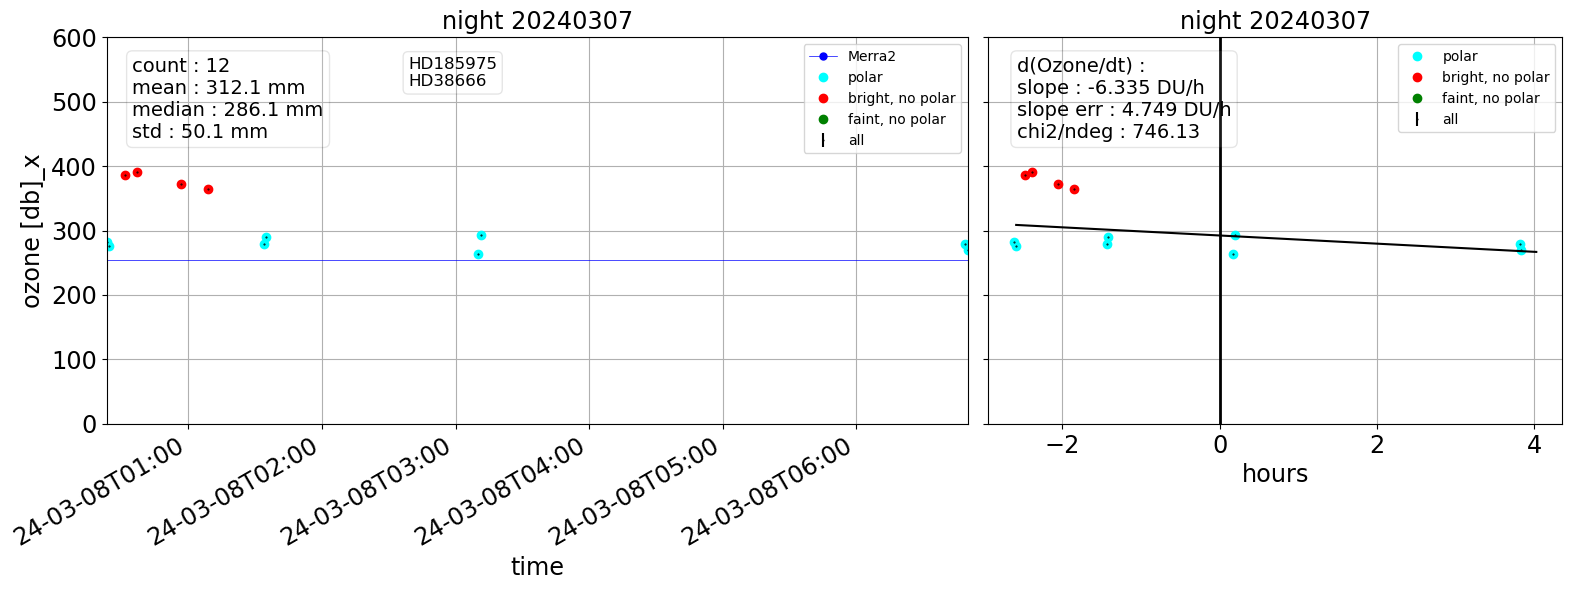

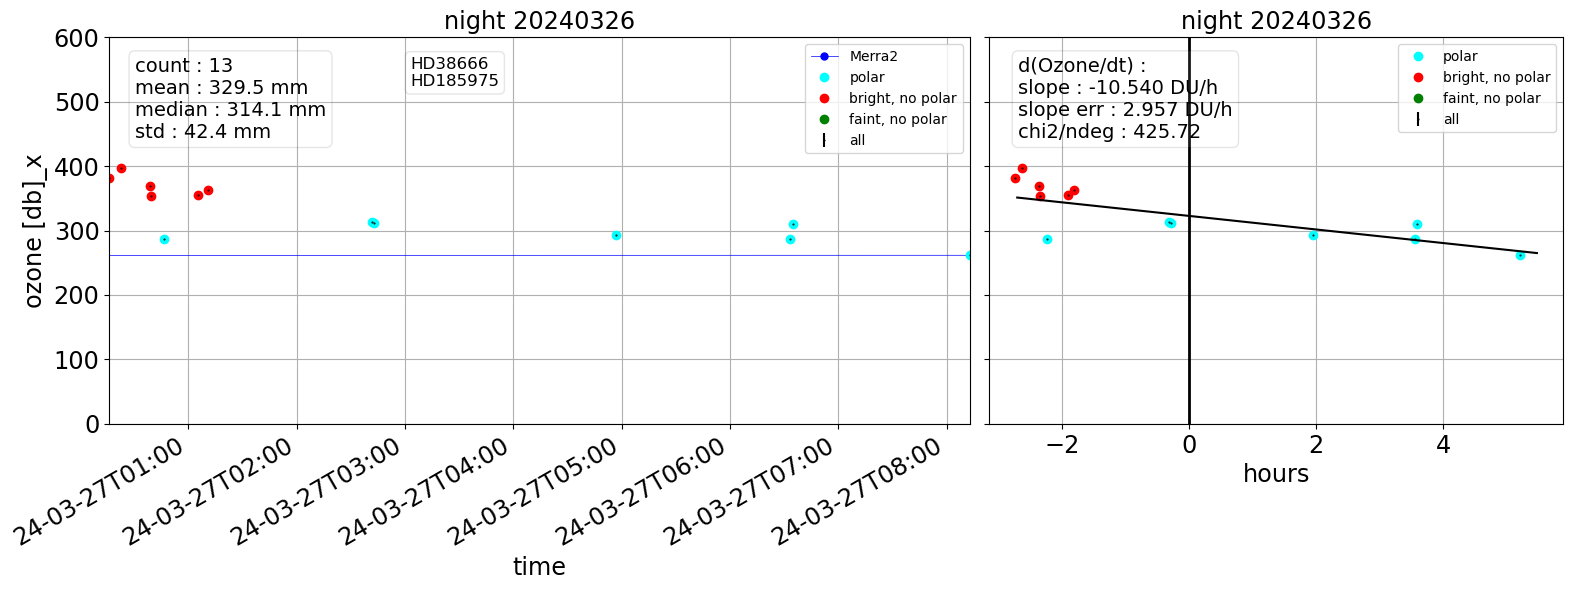

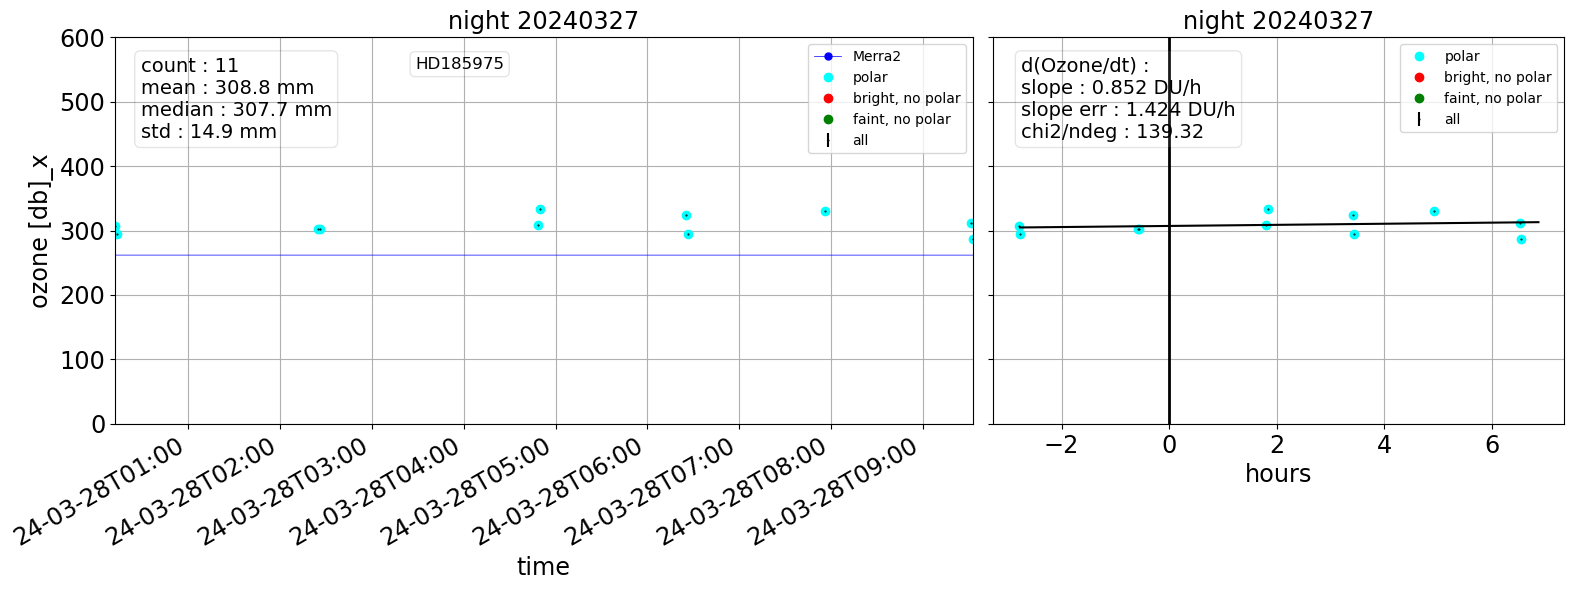

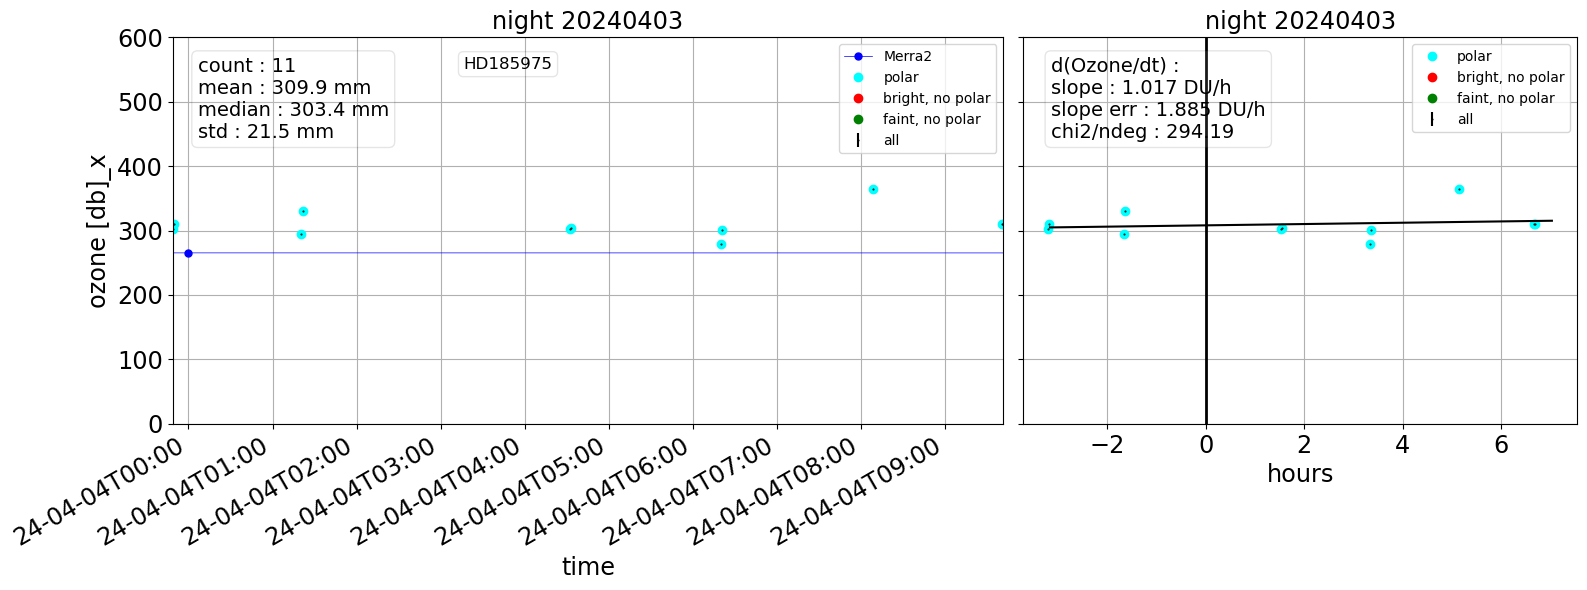

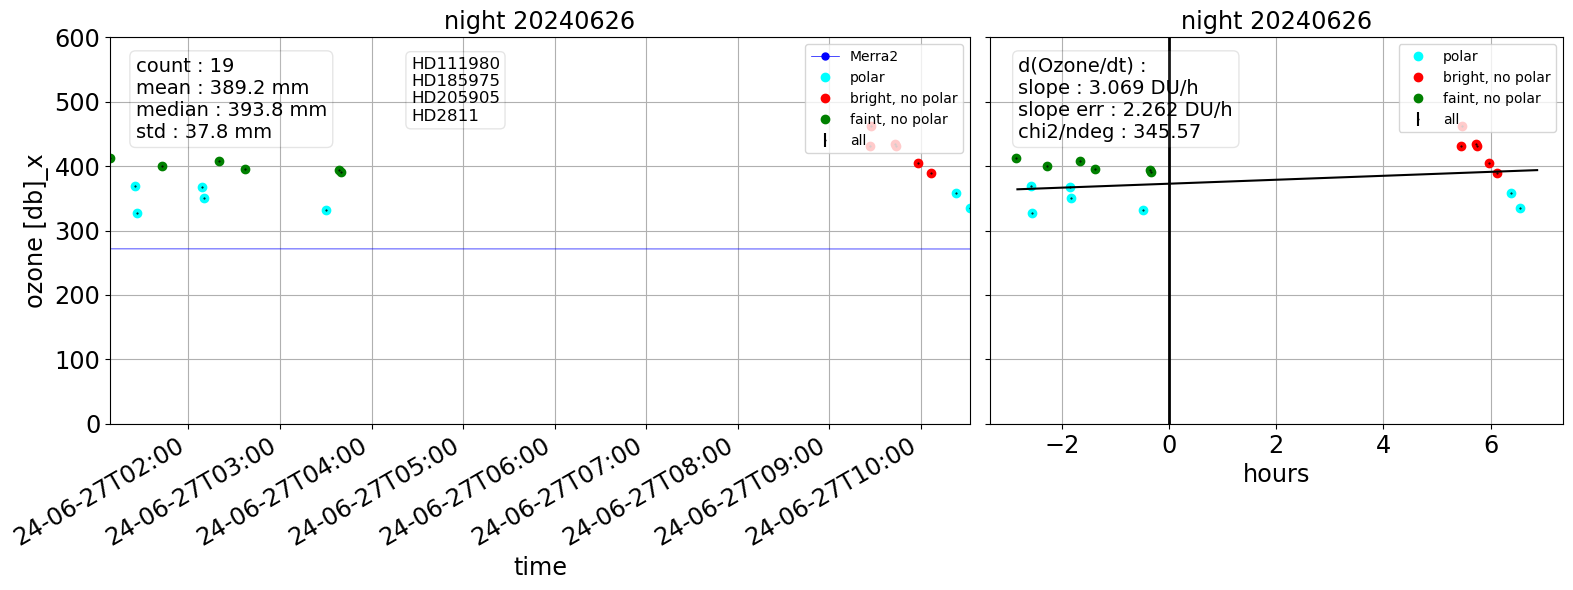

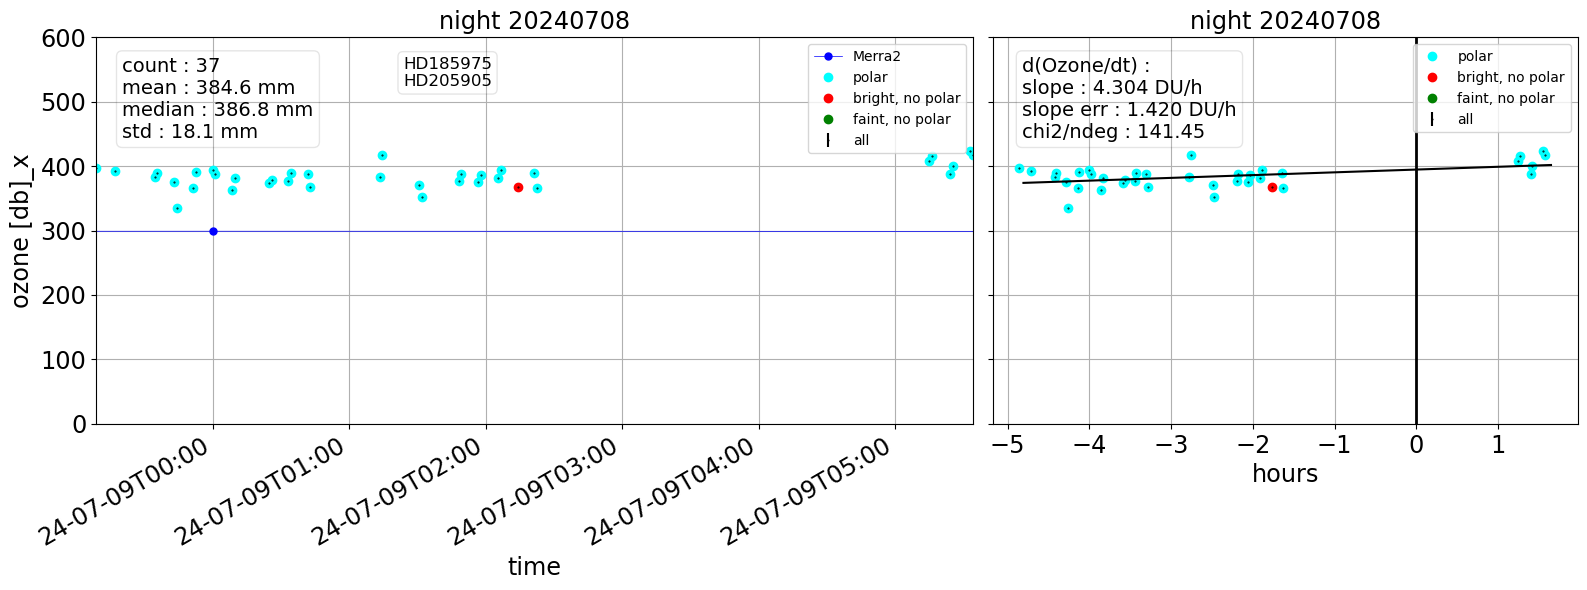

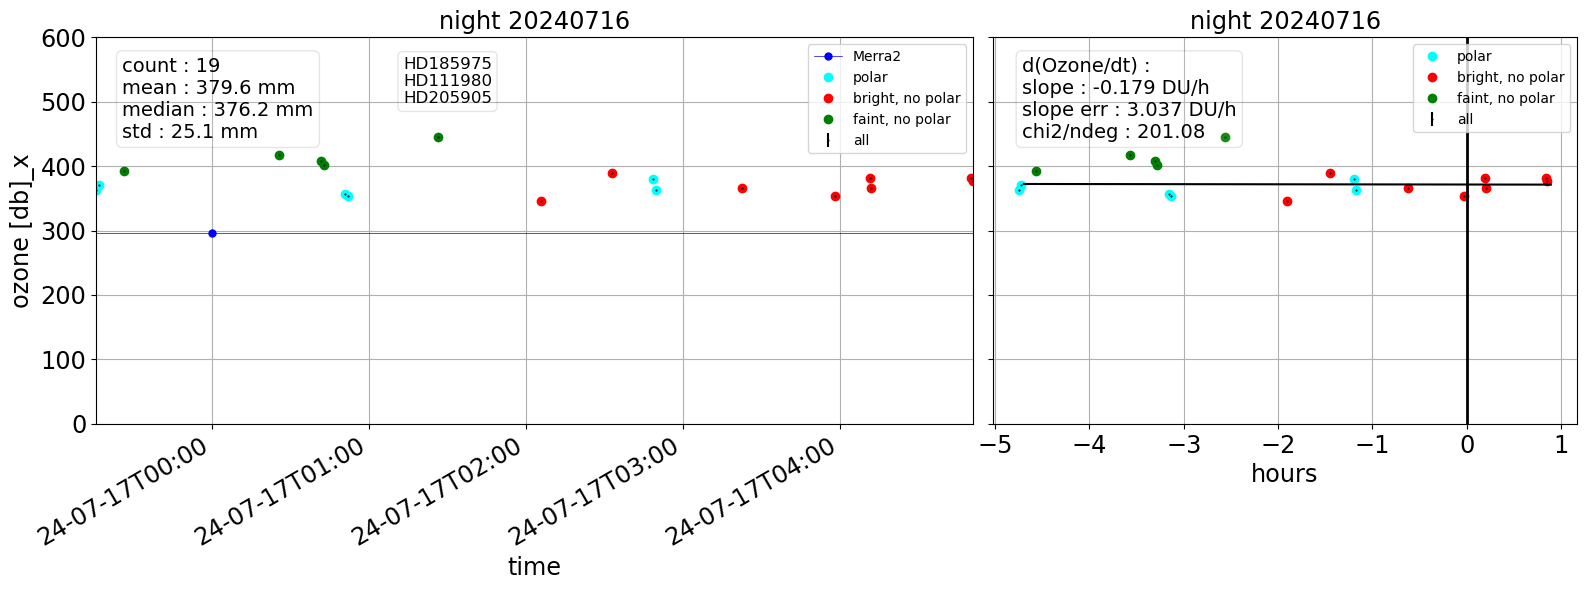

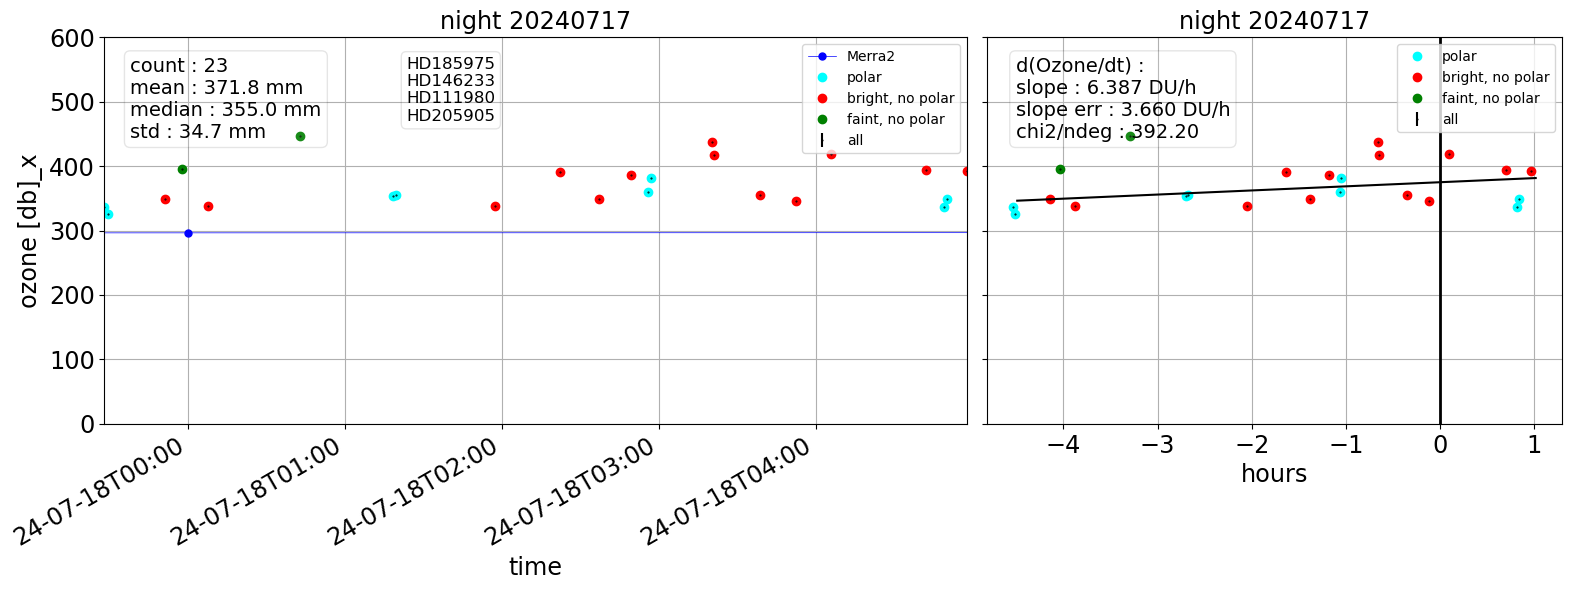

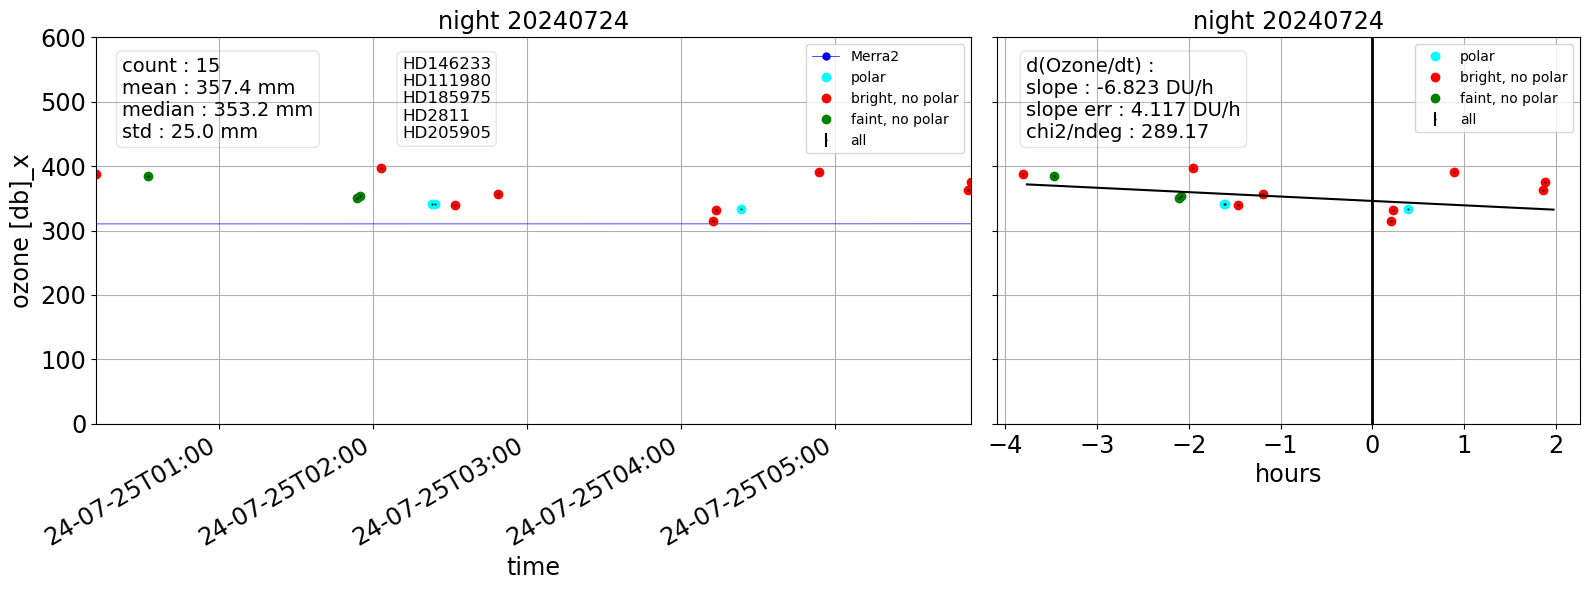

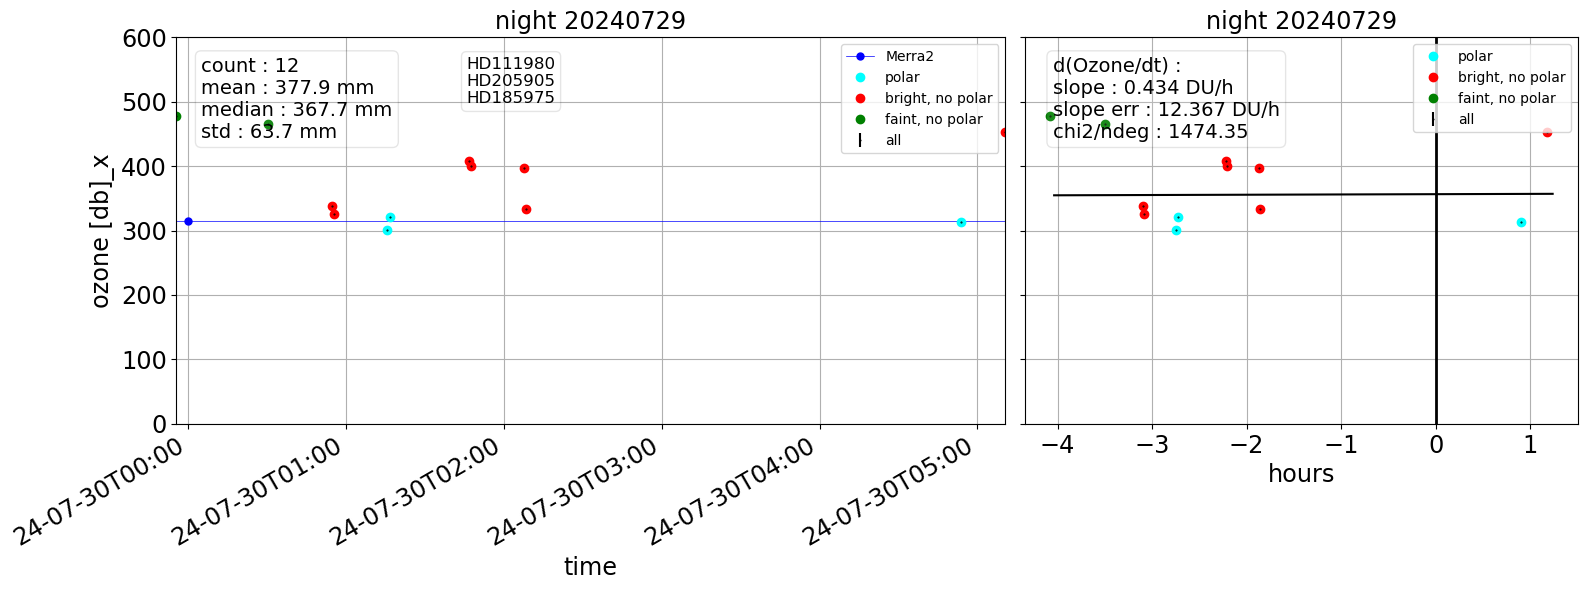

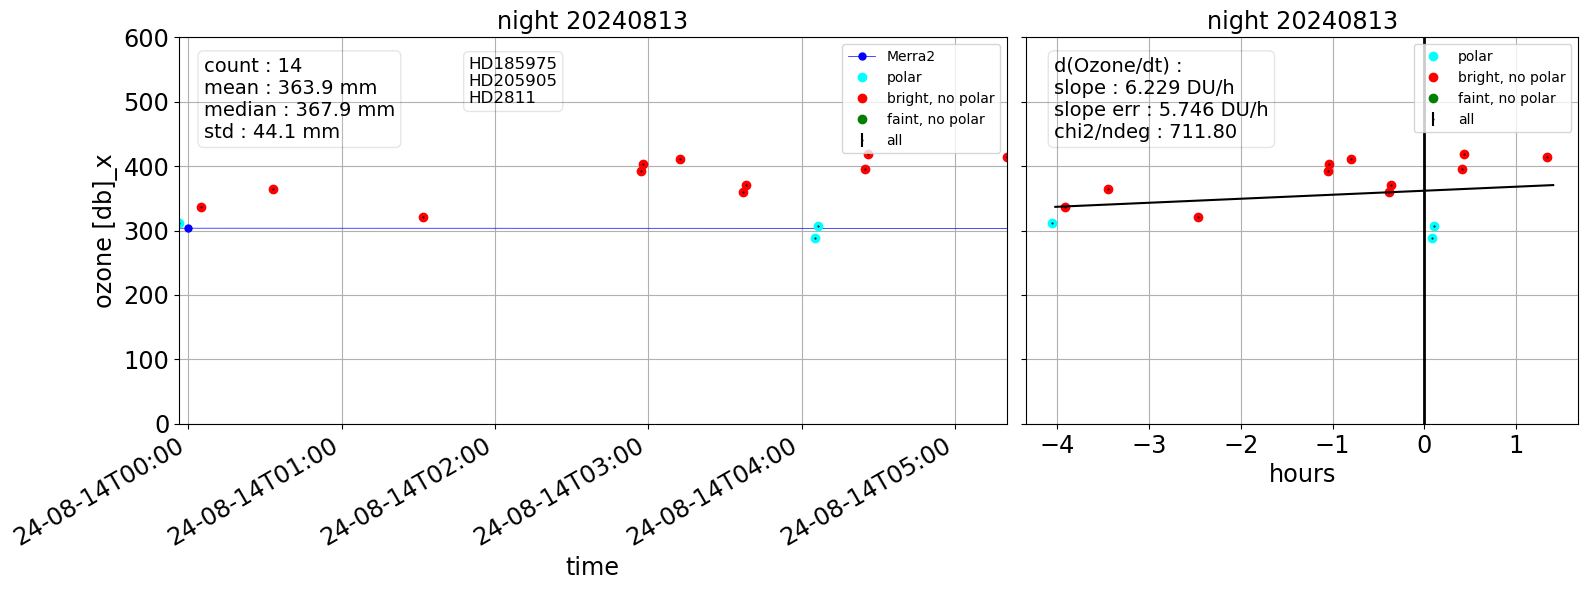

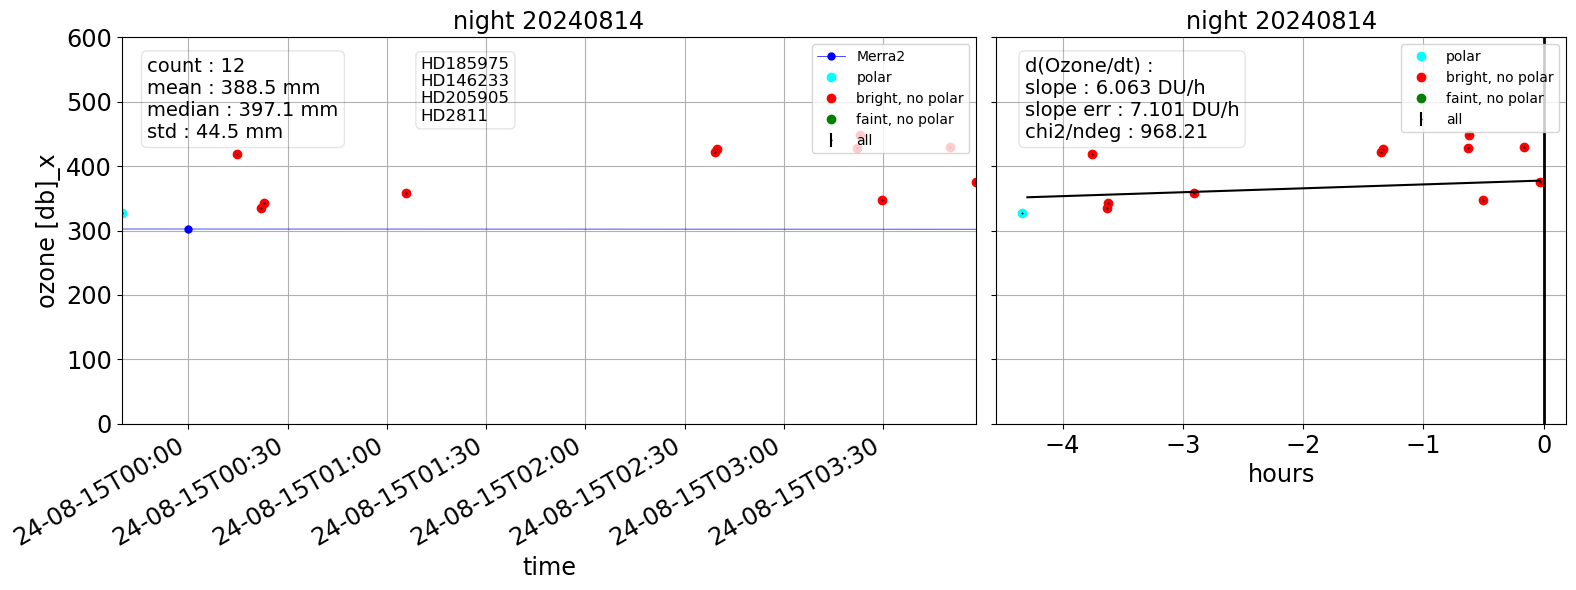

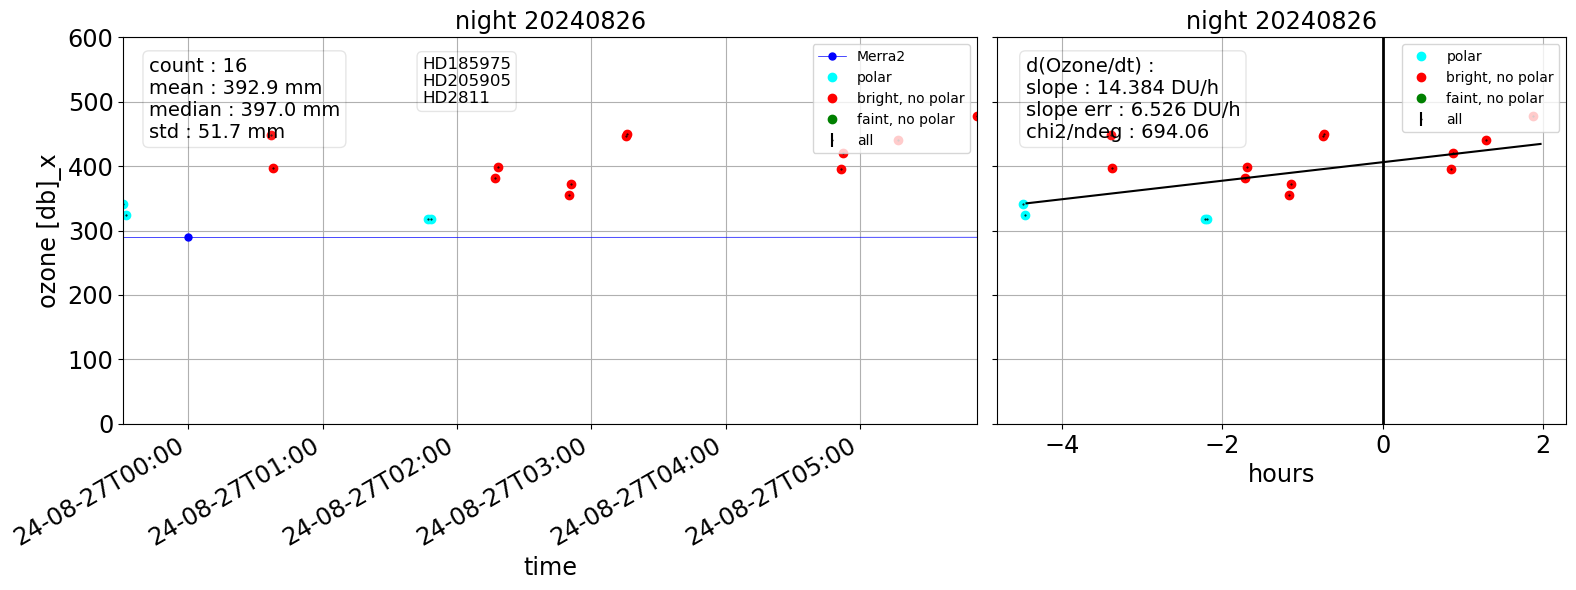

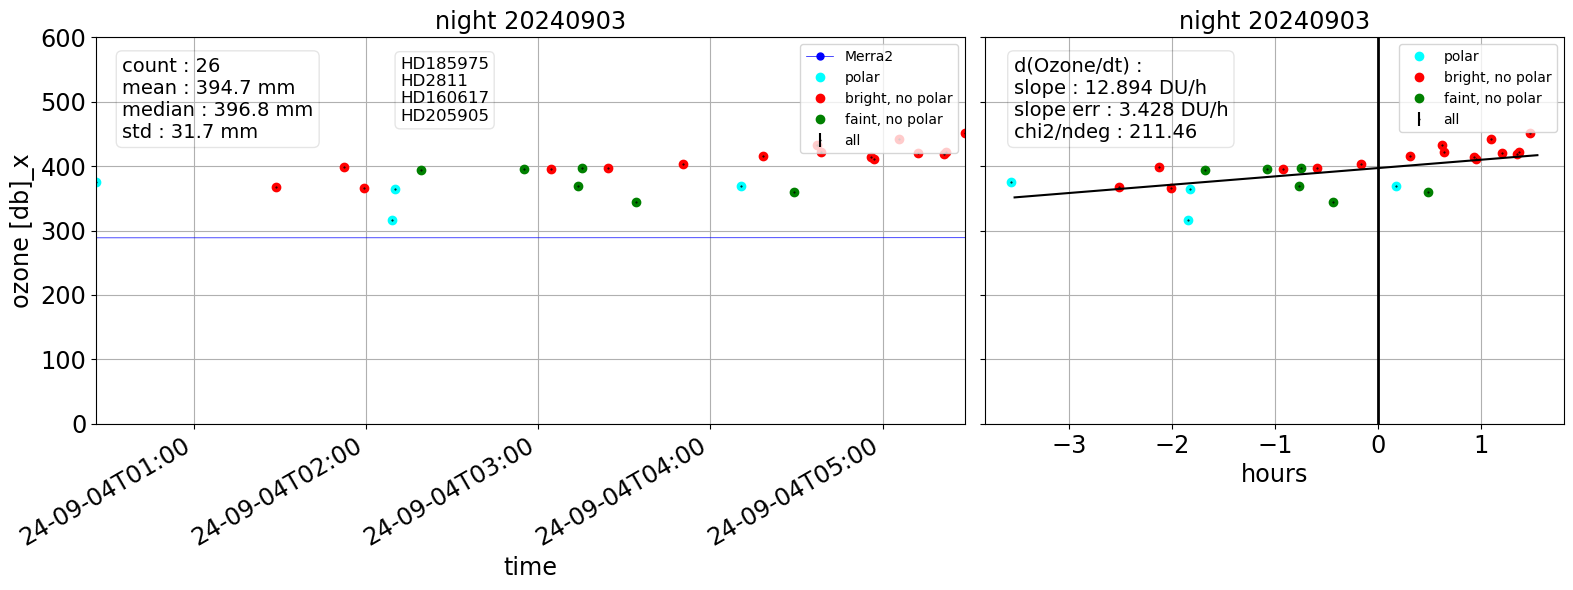

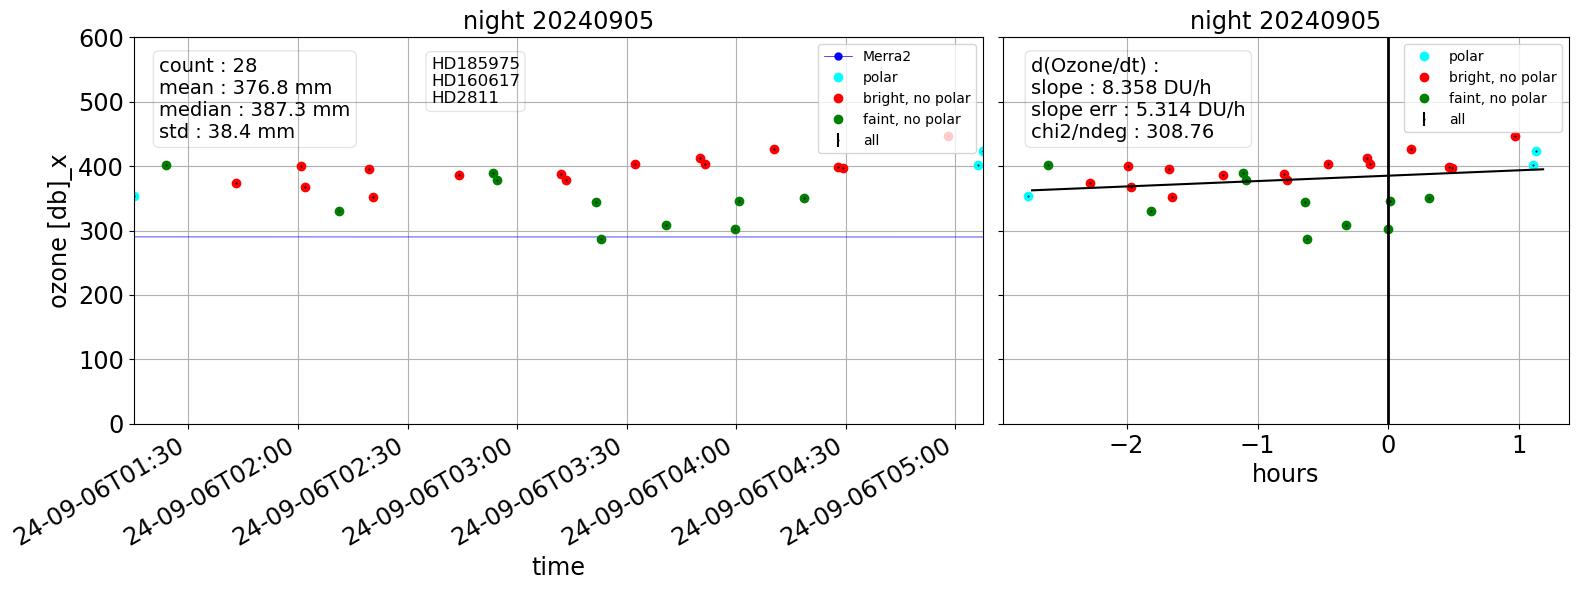

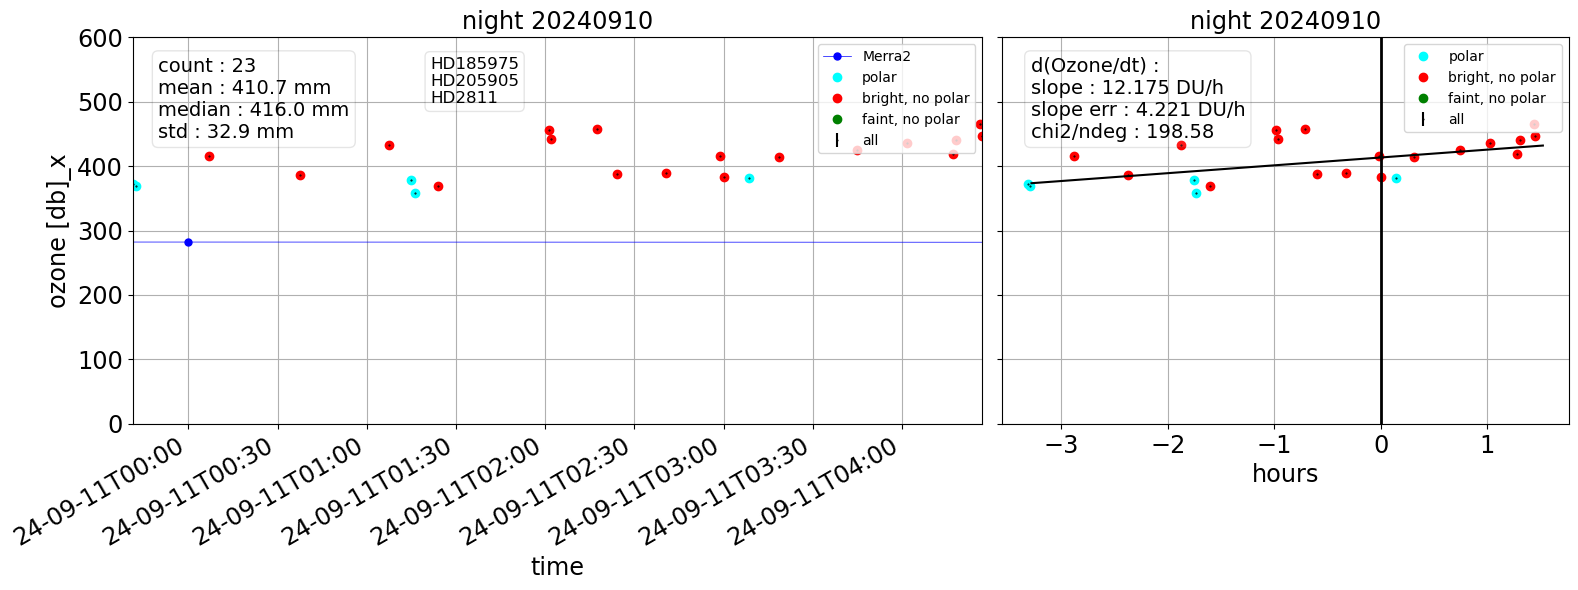

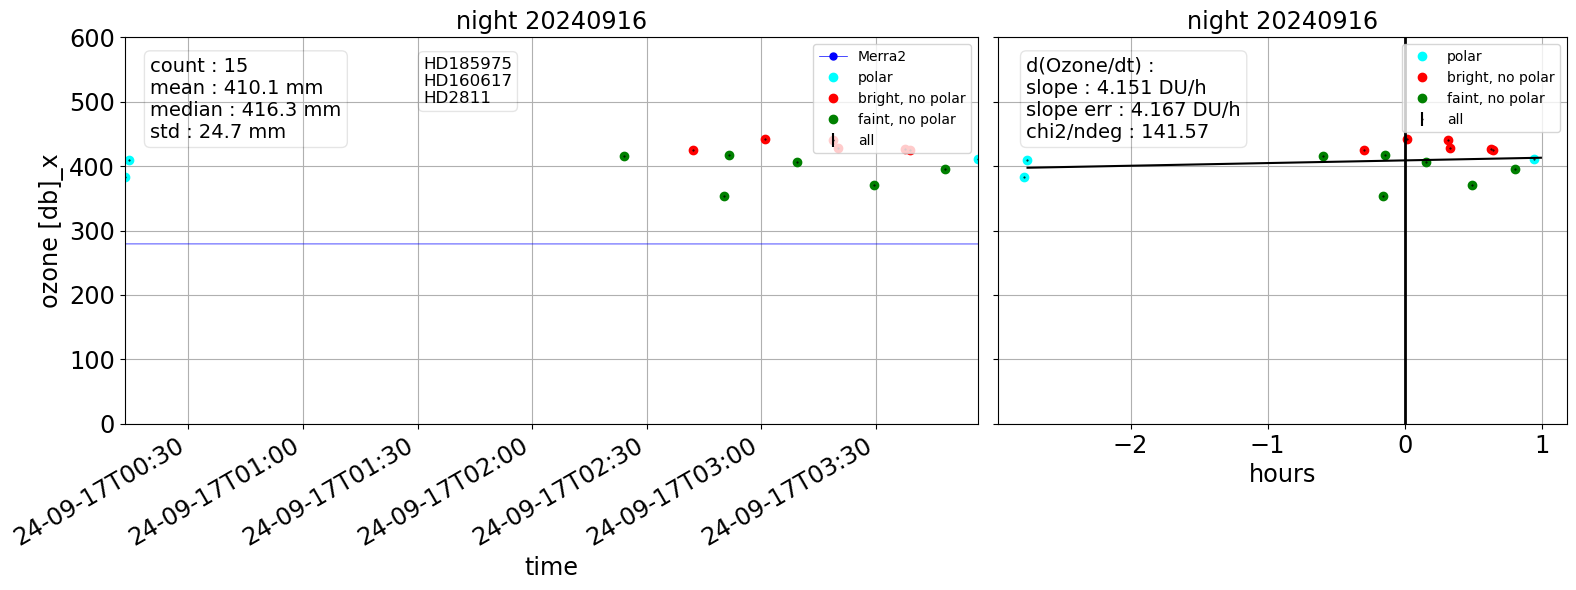

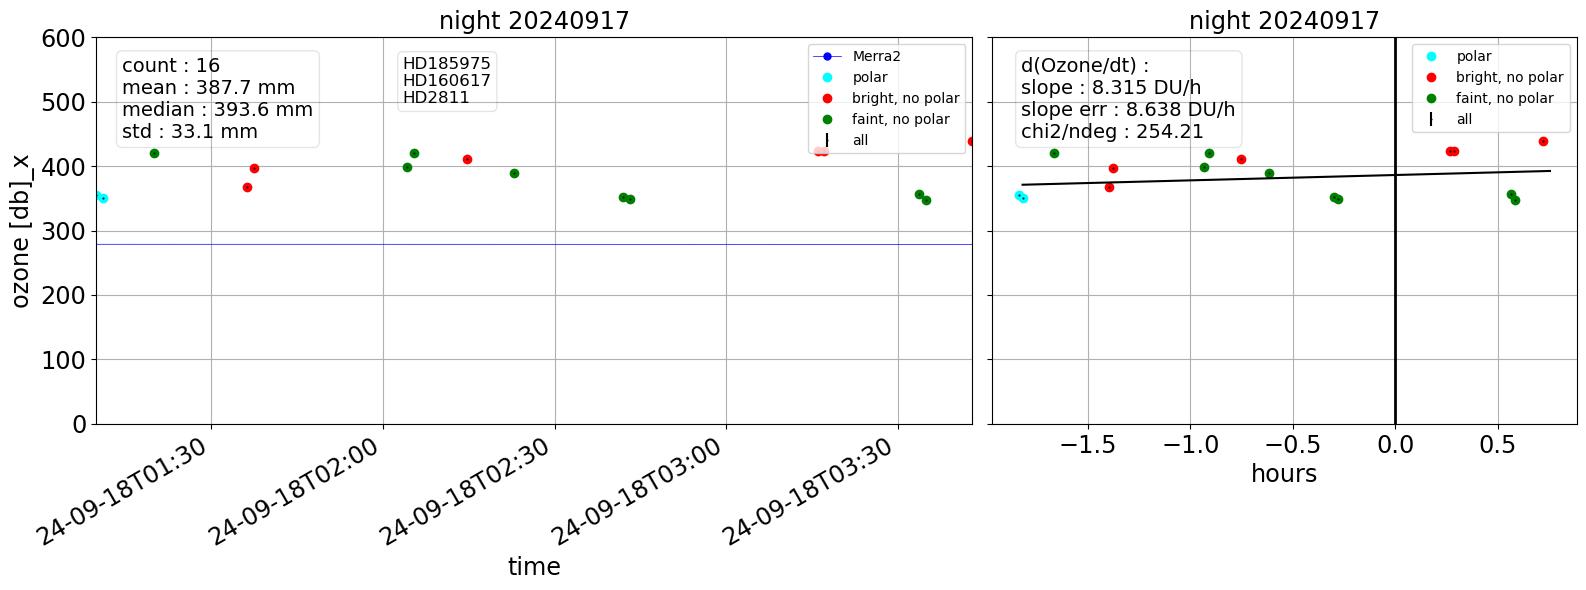

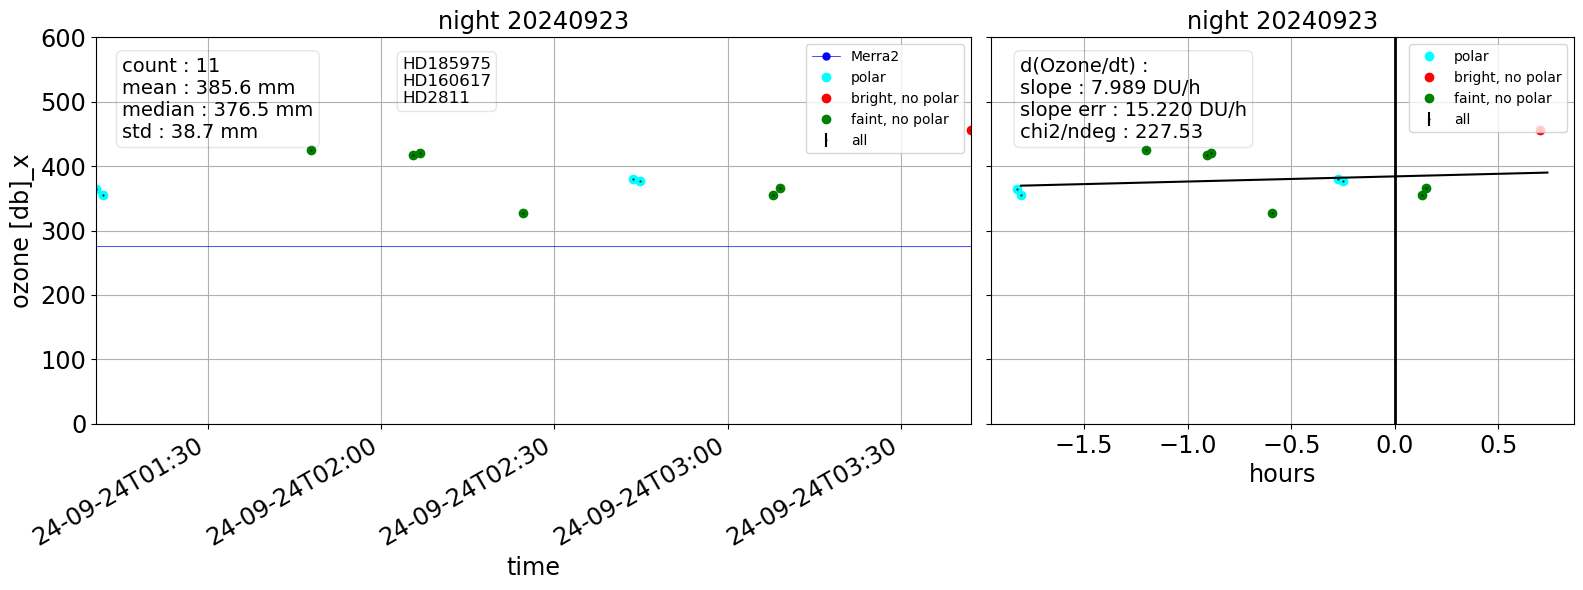

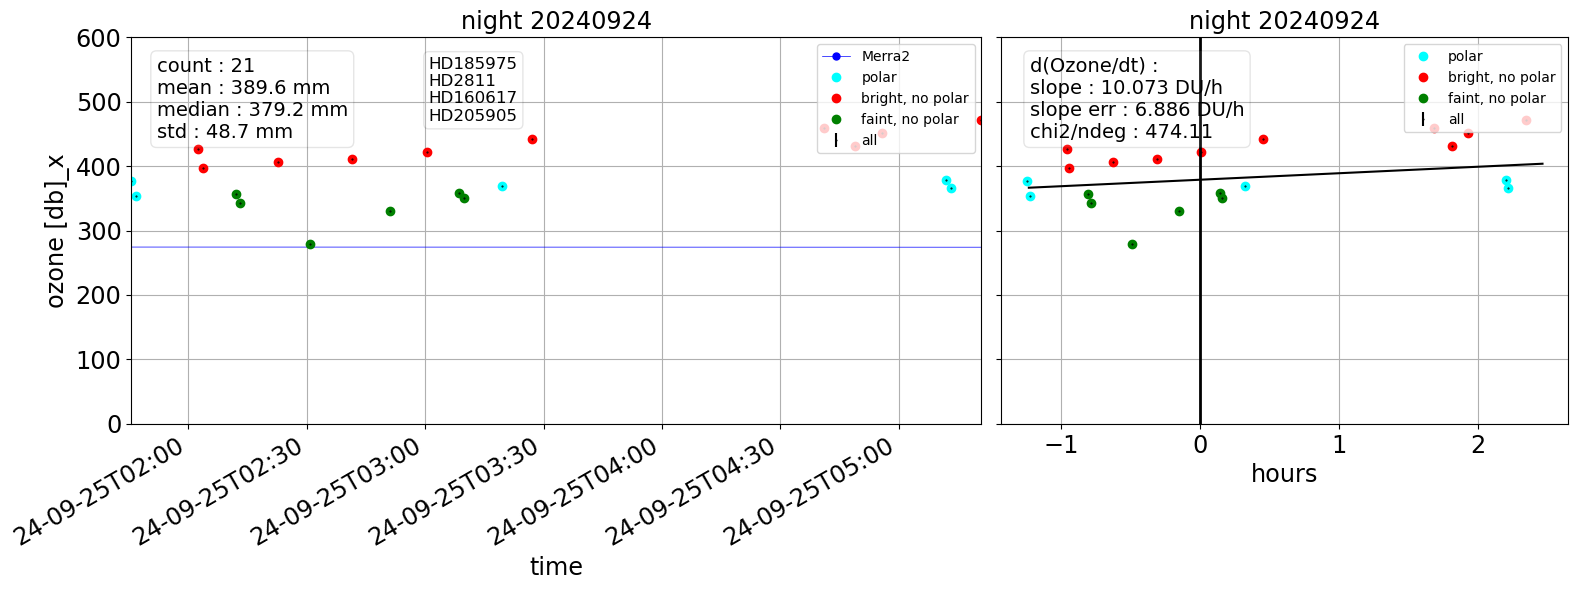

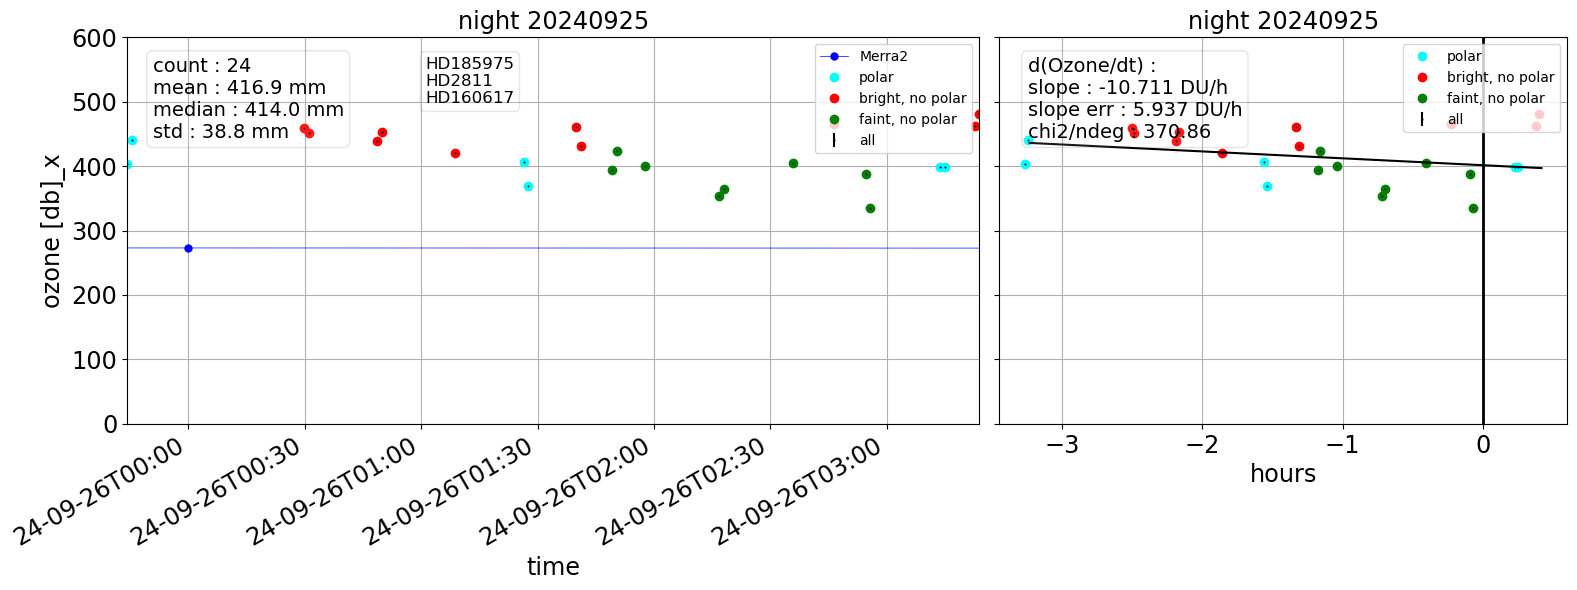

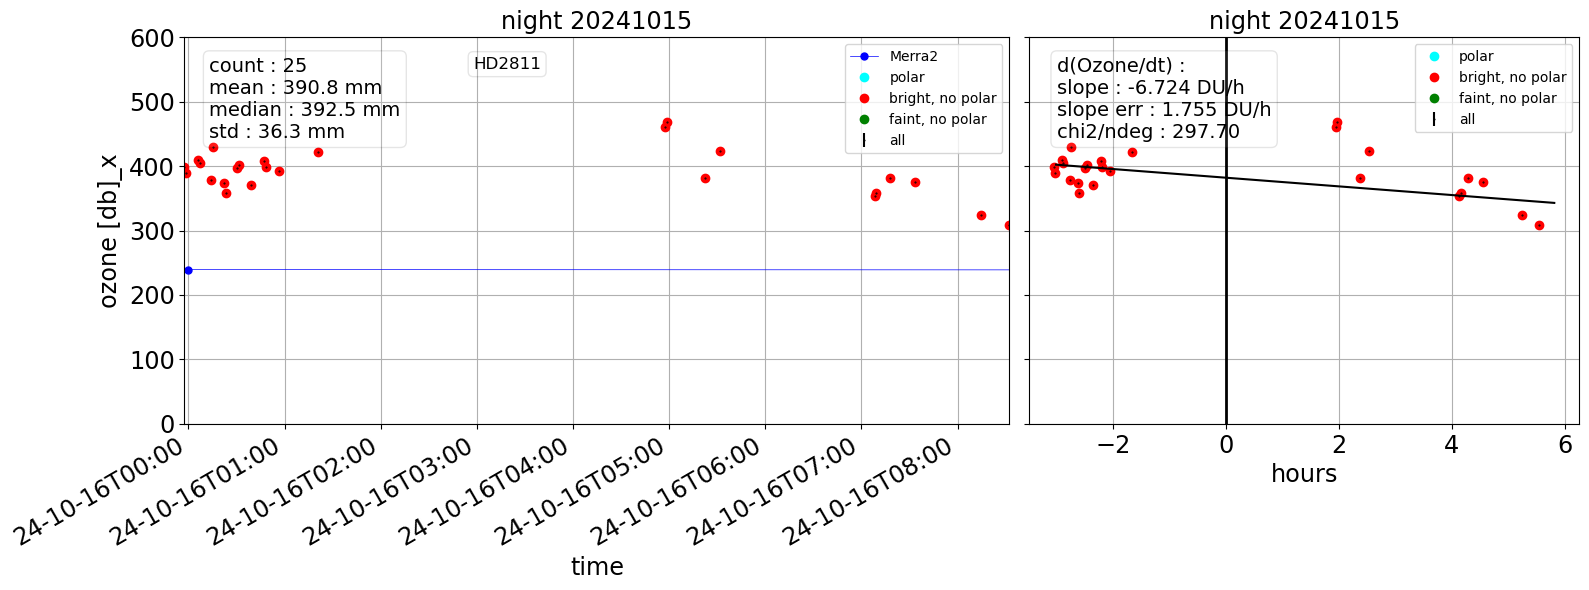

In [60]:
all_dateObs_sel = {}

# loop on nights
for night in all_selected_nights:
    #select the night
    
    # Choose the kind of observation
    df_spec_night = df_spec_sel[df_spec_sel["nightObs"] == night]
    df_spec_night_wp = df_spec_wp[df_spec_wp["nightObs"] == night]
    df_spec_night_np = df_spec_np[df_spec_np["nightObs"] == night]
    df_spec_night_np_f = df_spec_np_f[df_spec_np_f["nightObs"] == night]
    df_spec_night_np_b = df_spec_np_b[df_spec_np_b["nightObs"] == night]

    
    #select the variables
    df_night_o3_curve = df_spec_night[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_wp = df_spec_night_wp[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_np = df_spec_night_np[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_np_b = df_spec_night_np_b[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_np_f = df_spec_night_np_f[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]

    tmin = df_night_o3_curve["Time"].min()
    tmax = df_night_o3_curve["Time"].max()


    list_of_targets = df_night_o3_curve["TARGET"].unique()
    str_list_of_targets = "\n".join(list_of_targets)

    # convert in hours
    df_night_o3_curve["dt"] = (df_night_o3_curve["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_wp["dt"] = (df_night_o3_curve_wp["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_np["dt"] = (df_night_o3_curve_np["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_np_b["dt"] = (df_night_o3_curve_np_b["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_np_f["dt"] = (df_night_o3_curve_np_f["Time"] - tmin).dt.total_seconds()/3600.
    
    
    stat = df_night_o3_curve[["ozone [db]_x"]].describe()
    date_form = DateFormatter("%y-%m-%dT%H:%M")
    count = int(stat.loc["count"].values[0])
    mean = stat.loc["mean"].values[0]
    median = stat.loc["50%"].values[0]
    std = stat.loc["std"].values[0]
    textstr = "\n".join((f"count : {count}",
                     f"mean : {mean:.1f} mm",
                     f"median : {median:.1f} mm",
                     f"std : {std:.1f} mm",
                    ))


    

    N= len(df_night_o3_curve)

    if N>10:
        # does the fit
        
        x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err = MakeLineFit(df_night_o3_curve)
        
        textstr2 = "\n".join((f"d(Ozone/dt) : ",
                     f"slope : {slope:.3f} DU/h ",
                     f"slope err : {slope_err:.3f} DU/h",
                     f"chi2/ndeg : {chi2dof:.2f}",       
                    ))

        textstr3 = "\n".join((f"d(Ozone/dt) : ",
                     f"slope : {slope:.3f} DU/h ",
                     f"slope err : {slope_err:.3f} DU/h",  
                    ))
    

        stat.loc["slope","ozone [db]_x"] = slope 
        stat.loc["slope_err","ozone [db]_err_x"] = slope_err 
        stat.loc["chi2","ozone [db]_x"] = chi2dof
        
        # plot
        
        fig = plt.figure(figsize=(16,6))
        gs = GridSpec(1, 2,  width_ratios=[1.5,1],figure=fig)

        # left figure
        ax = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1],sharey=ax)
        #ax2 = fig.add_subplot(gs[1])
        ax.set_xlim(tmin,tmax)
        df_m.plot(x="Time",y="TO3",ax=ax,marker="o",c="b",lw=0.5,ms=5,label="Merra2",legend=leg)  
        #df_night_o3_curve.plot(x="Time",y="ozone [db]_x",ax=ax,marker='+',c="k",lw=0.0,grid=True,legend=leg,label="all",ms=8)
        ax.errorbar(x=df_night_o3_curve.Time, y=df_night_o3_curve["ozone [db]_x"],yerr=df_night_o3_curve["ozone [db]_err_x"],fmt=".",color="k",ecolor="k",ms=1,label='all')
        df_night_o3_curve_wp.plot(x="Time",y="ozone [db]_x",c="cyan",ax=ax,marker='o',lw=0.0,grid=True,legend=leg2,label="polar",ms=6,alpha=1)
        df_night_o3_curve_np_b.plot(x="Time",y="ozone [db]_x",c="r",ax=ax,marker='o',lw=0.0,grid=True,legend=leg2,label="bright, no polar",ms=6,alpha=1)
        df_night_o3_curve_np_f.plot(x="Time",y="ozone [db]_x",c="g",ax=ax,marker='o',lw=0.0,grid=True,legend=leg2,label="faint, no polar",ms=6,alpha=1)
        
        
        ax.legend(loc="upper right")
        ax.set_ylabel("ozone [db]_x")
        ax.set_xlabel("time")
        ax.xaxis.set_major_formatter(date_form)
        ax.set_ylim(0.,600.)
        ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
        #ax.text(0.35, 0.95, textstr3, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        ax.text(0.35, 0.95, str_list_of_targets, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        ax.set_title(f"night {night}")
        
        # right figure
        ax2.errorbar(x=df_night_o3_curve.dt_midnight, y=df_night_o3_curve["ozone [db]_x"],yerr=df_night_o3_curve["ozone [db]_err_x"],fmt=".",color="k",ecolor="k",ms=1,label="all")
        df_night_o3_curve_wp.plot(x="dt_midnight",y="ozone [db]_x",c="cyan",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg,label="polar",ms=6,alpha=1)
        df_night_o3_curve_np_b.plot(x="dt_midnight",y="ozone [db]_x",c="r",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg,label="bright, no polar",ms=6,alpha=1)
        df_night_o3_curve_np_f.plot(x="dt_midnight",y="ozone [db]_x",c="g",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg,label="faint, no polar",ms=6,alpha=1)
        
        ax2.set_xlabel("hours")
        ax2.set_ylim(0.,600.)
        ax2.legend(loc="upper right")
        ax2.plot(xfit,yfit,"k-")
        ax2.text(0.05, 0.95, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        ax2.set_title(f"night {night}")
        ax2.axvline(x=0,color="k",lw=2)
        
        plt.tight_layout()
        figname =f"{pathfigs}/o3_per_night_{night}"+figtype
        plt.savefig(figname)
        plt.show()

        # add statistics
        all_dateObs_sel[night] = stat

### Version v2 for Blois Conference

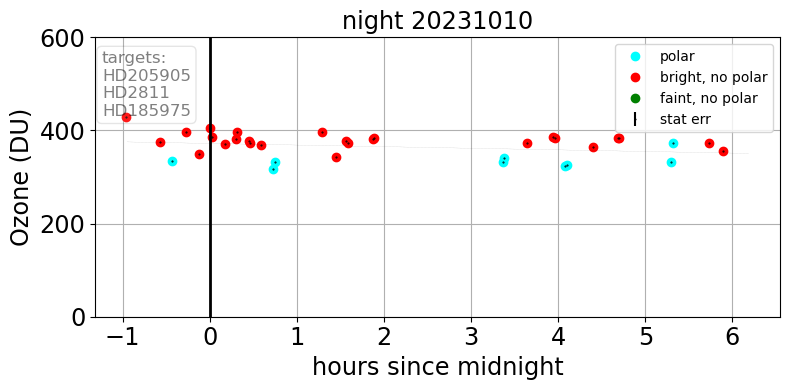

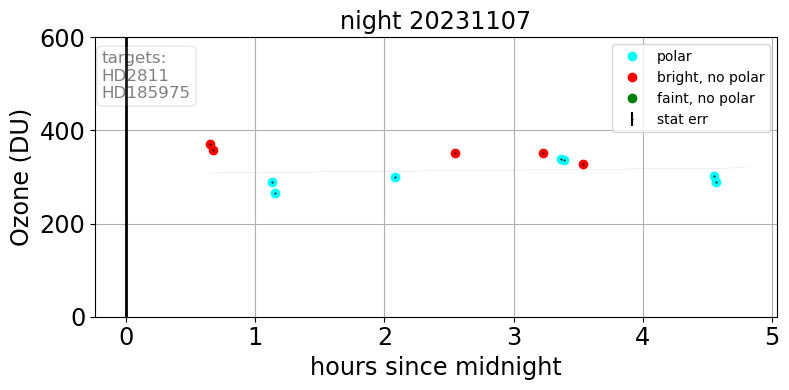

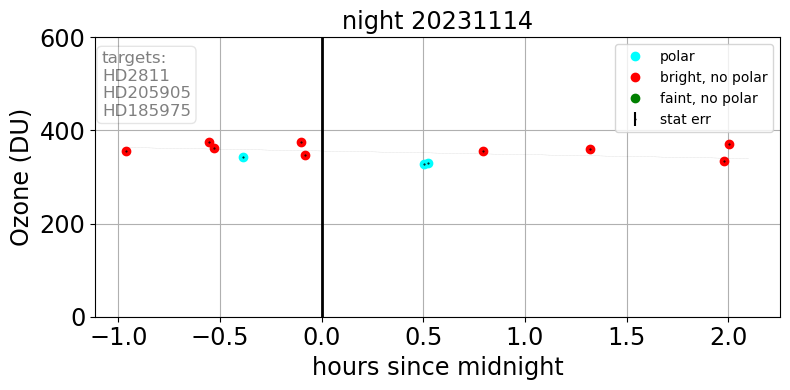

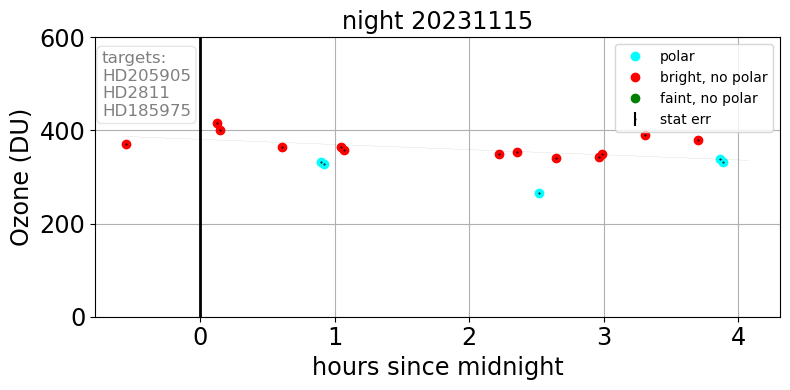

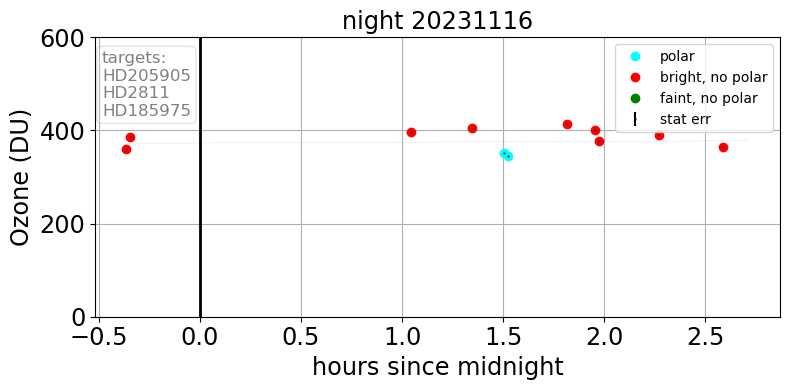

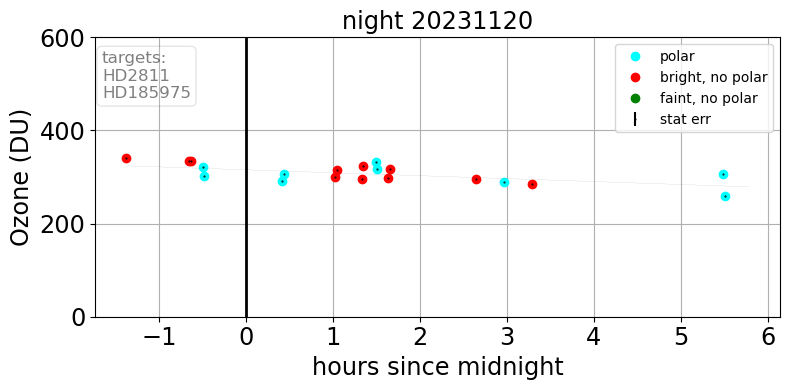

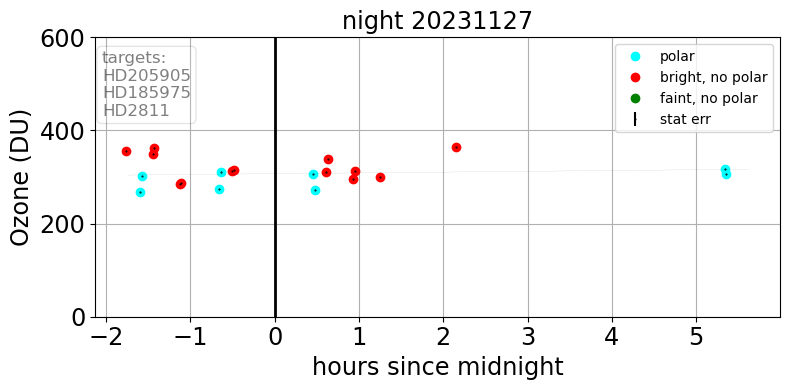

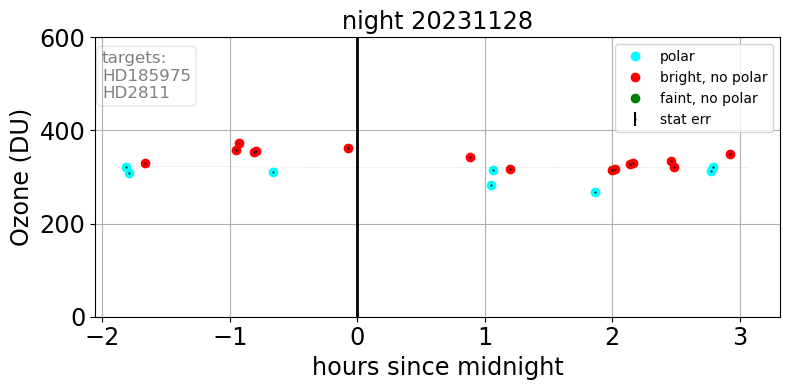

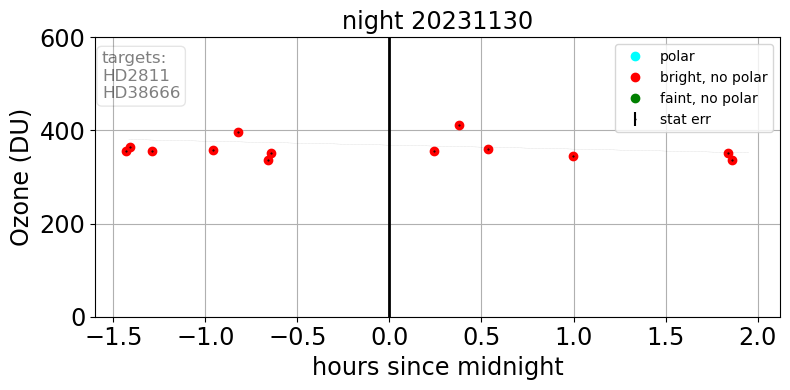

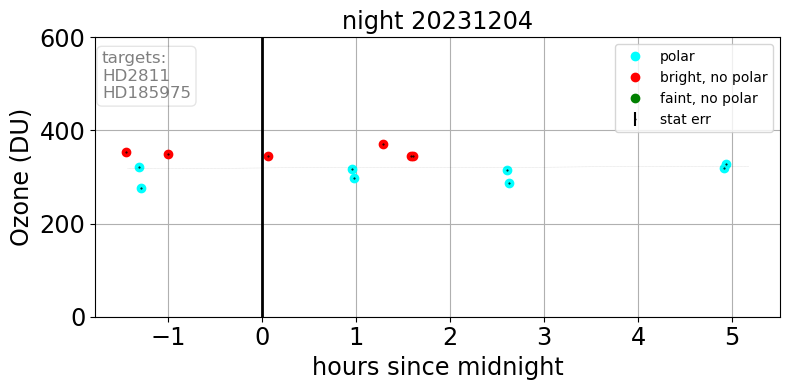

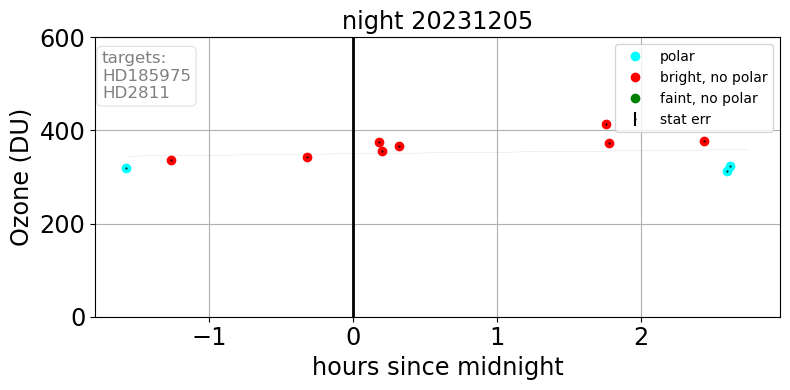

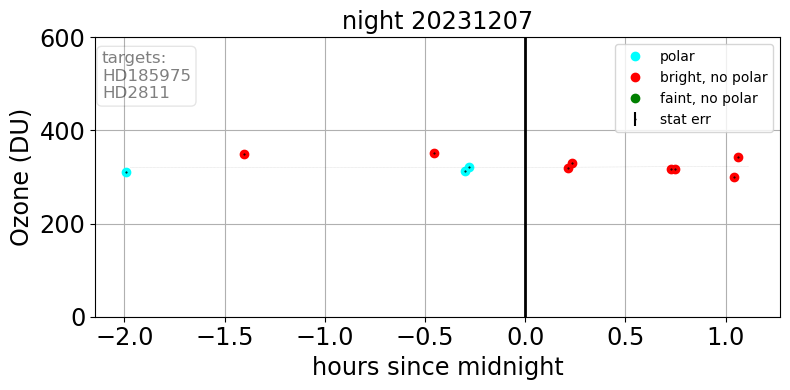

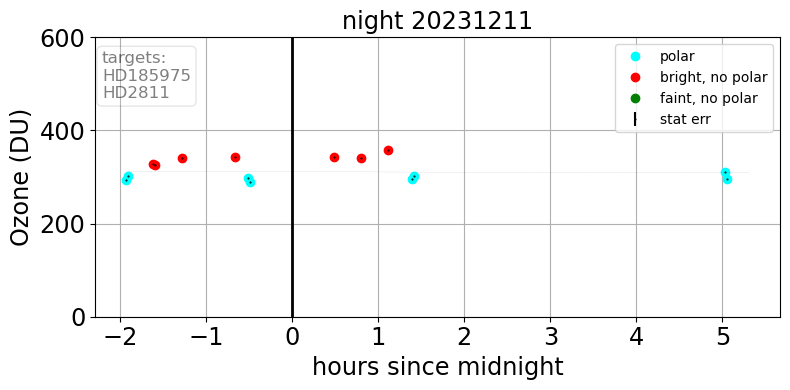

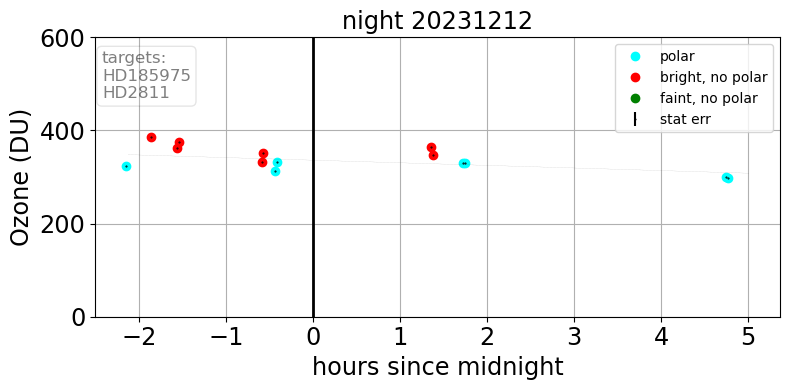

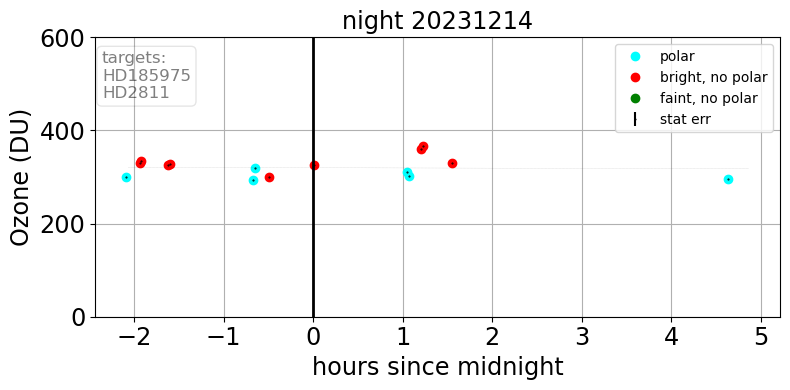

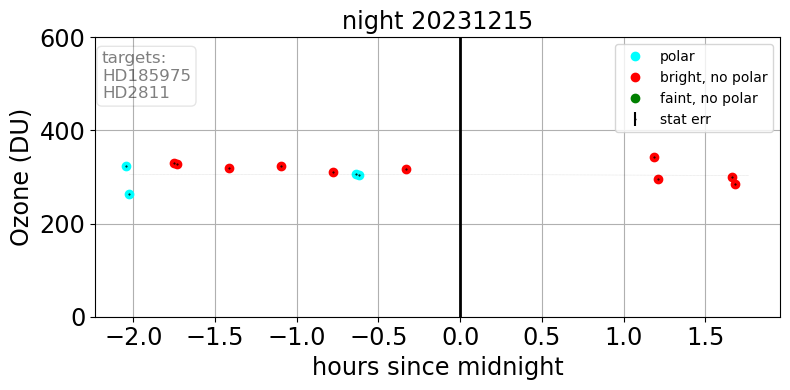

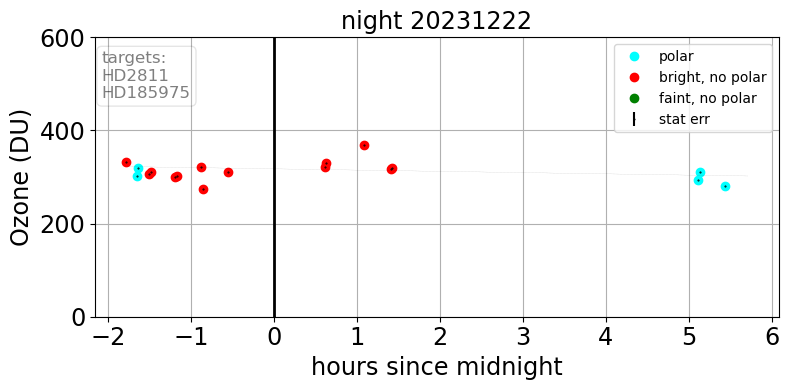

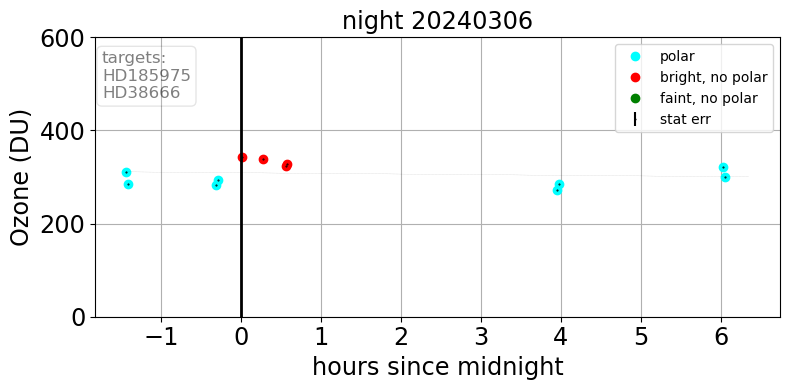

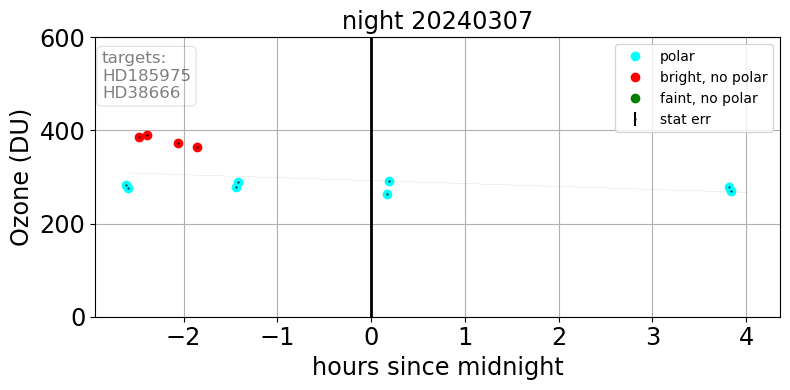

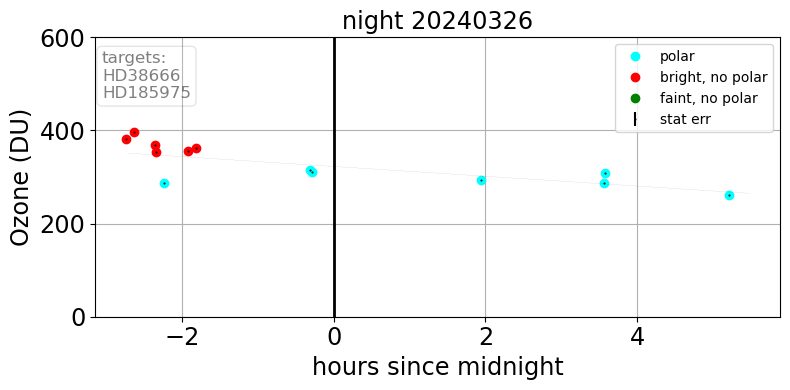

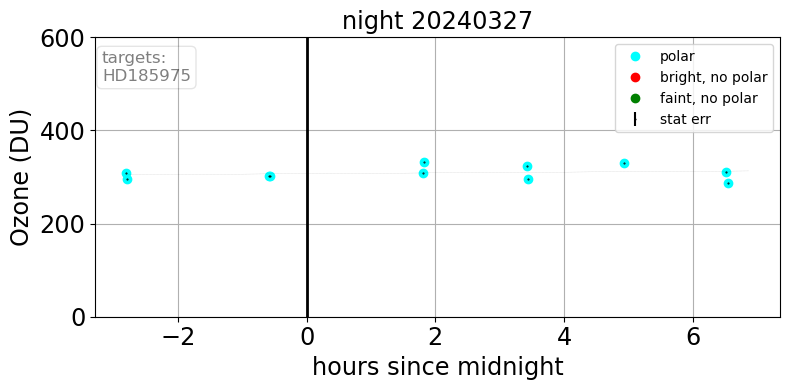

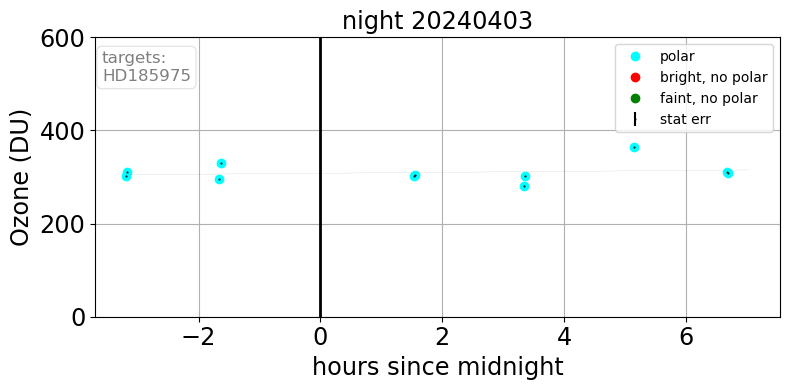

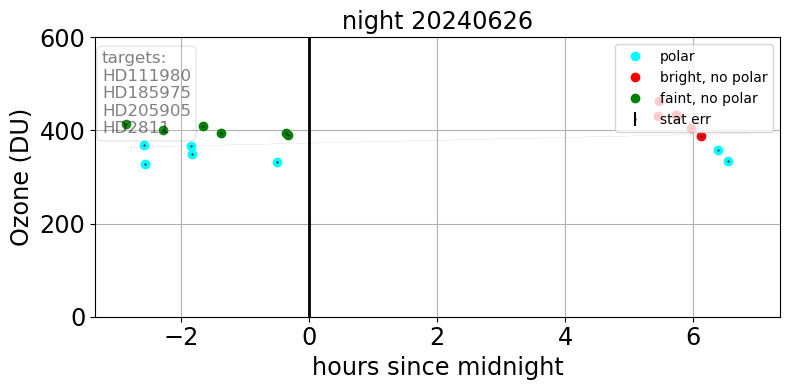

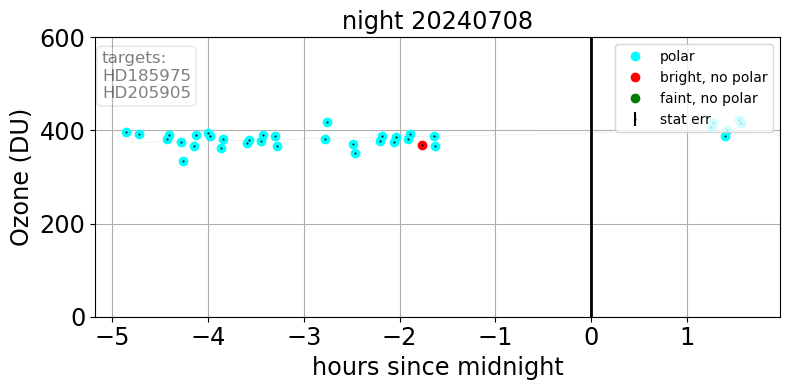

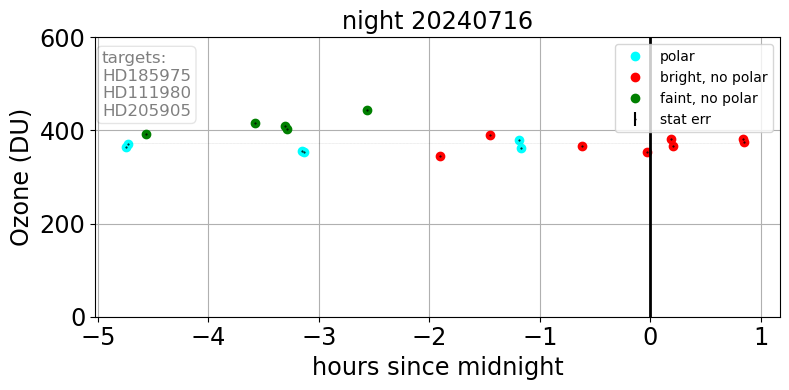

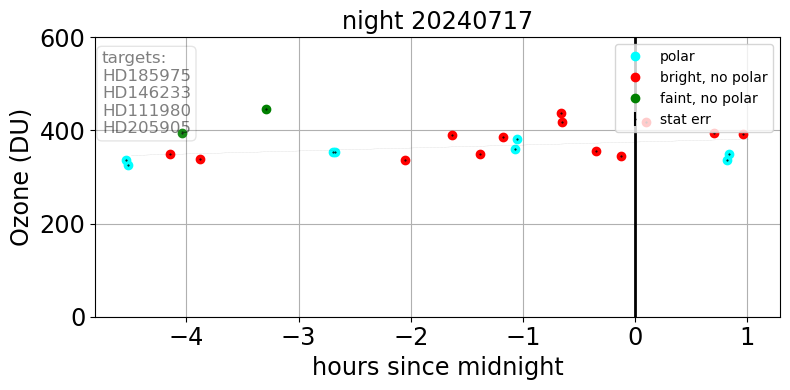

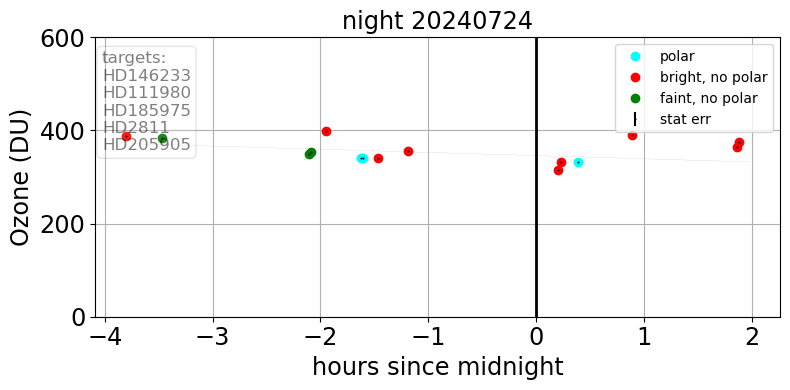

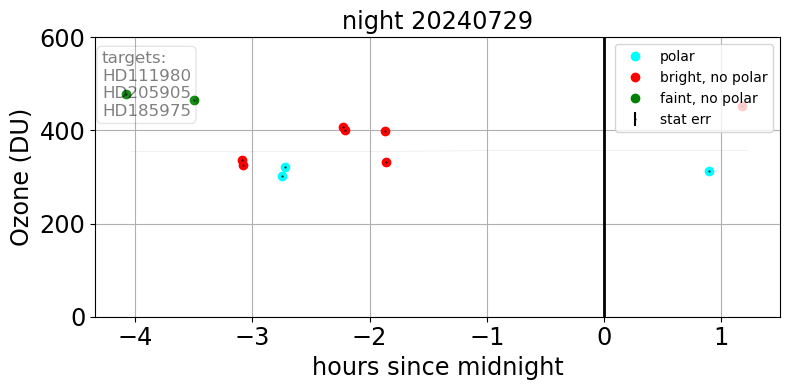

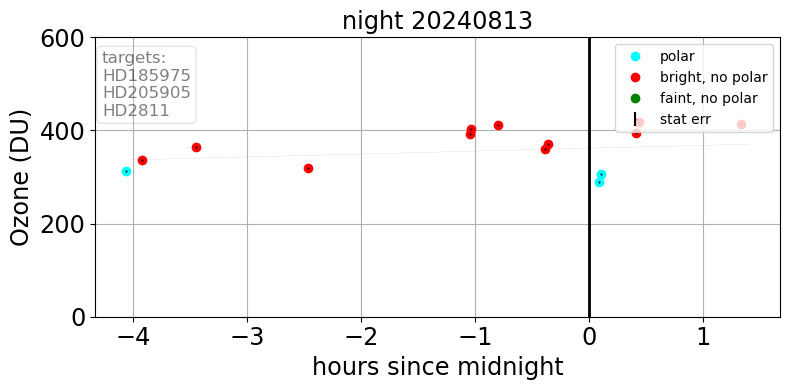

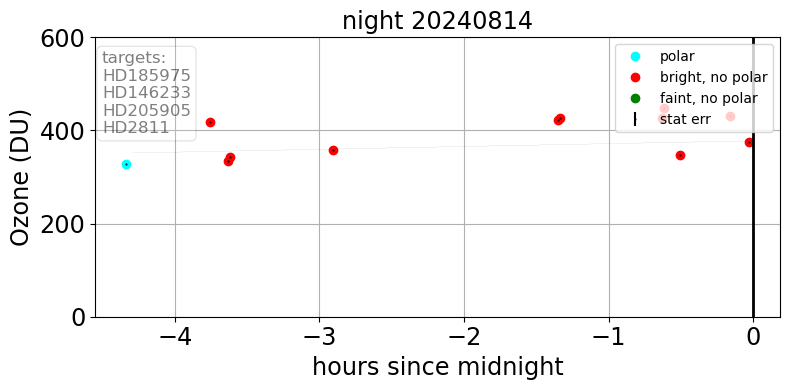

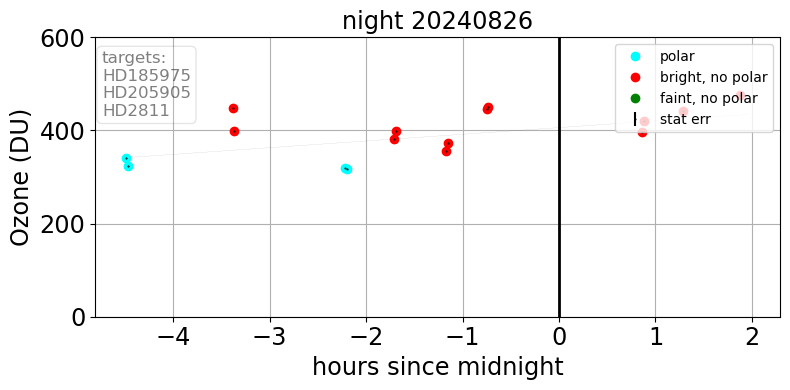

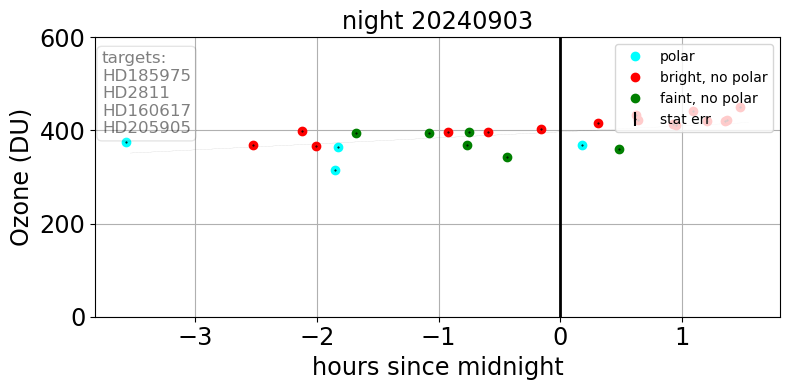

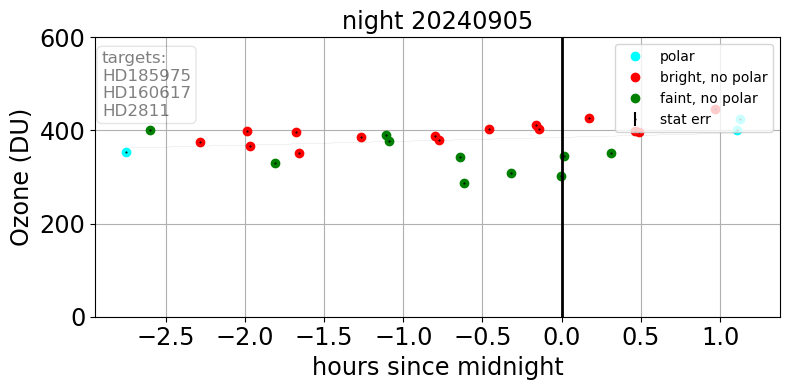

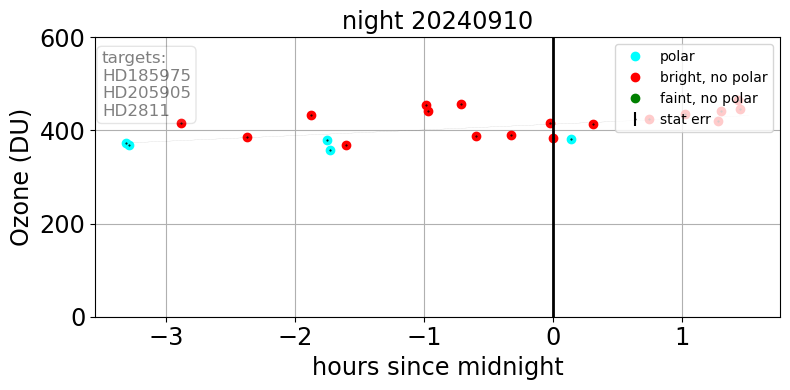

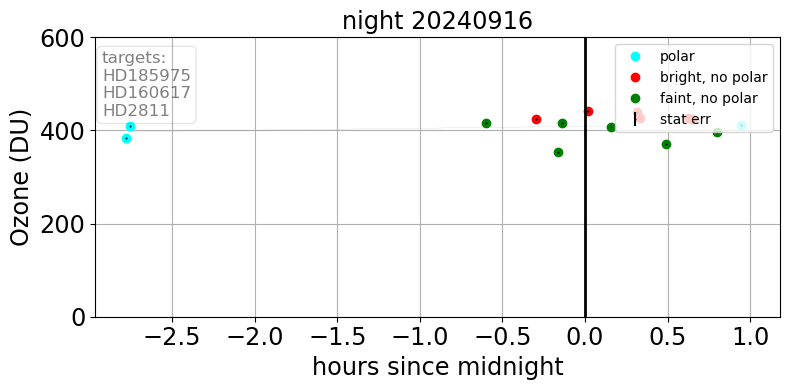

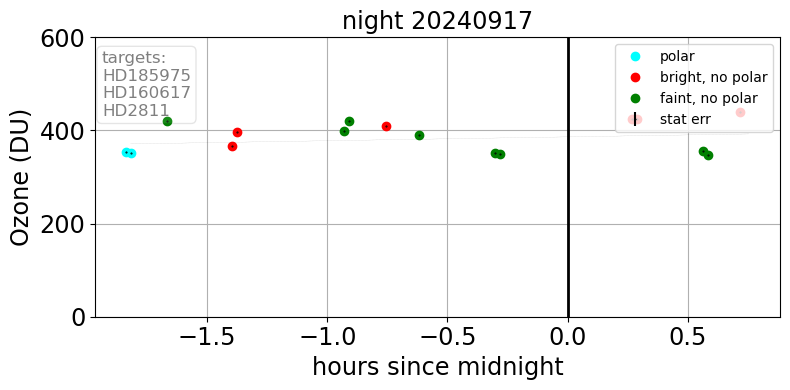

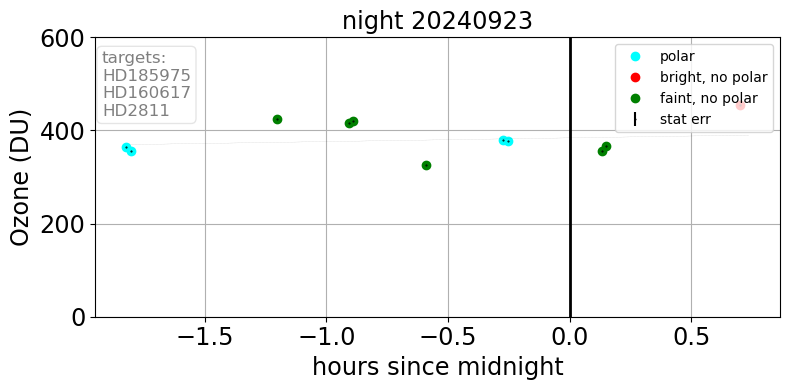

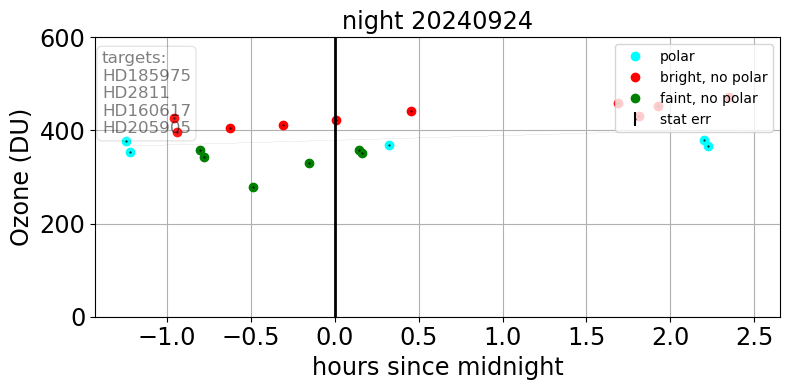

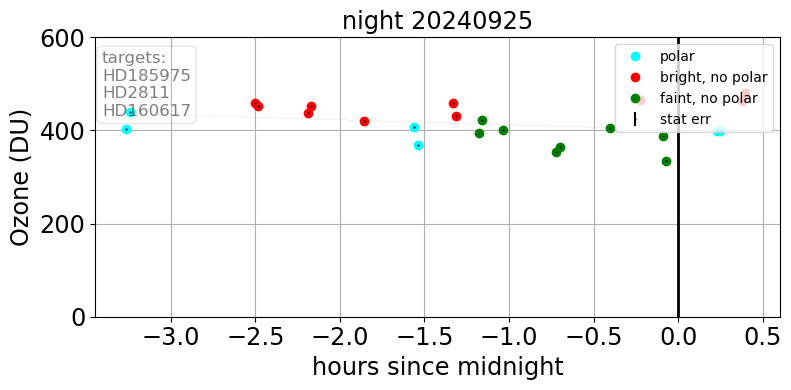

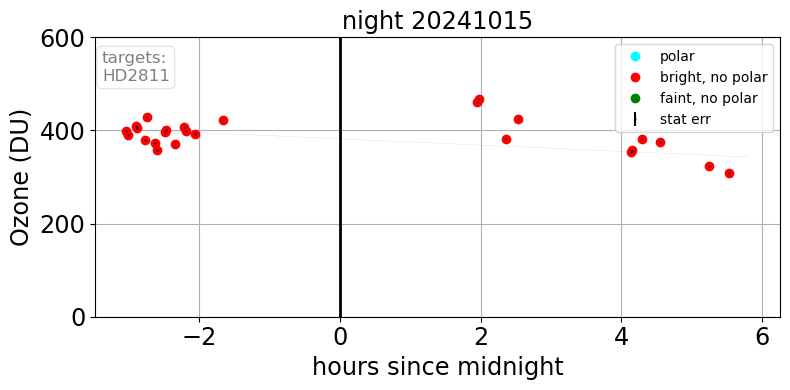

In [61]:


# loop on nights
for night in all_selected_nights:
    #select the night
    
    # Choose the kind of observation
    df_spec_night = df_spec_sel[df_spec_sel["nightObs"] == night]
    df_spec_night_wp = df_spec_wp[df_spec_wp["nightObs"] == night]
    df_spec_night_np = df_spec_np[df_spec_np["nightObs"] == night]
    df_spec_night_np_f = df_spec_np_f[df_spec_np_f["nightObs"] == night]
    df_spec_night_np_b = df_spec_np_b[df_spec_np_b["nightObs"] == night]

    
    #select the variables
    df_night_o3_curve = df_spec_night[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_wp = df_spec_night_wp[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_np = df_spec_night_np[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_np_b = df_spec_night_np_b[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_o3_curve_np_f = df_spec_night_np_f[["Time","ozone [db]_x","ozone [db]_err_x","ozone [db]_y","ozone [db]_err_y","dt_midnight","AIRMASS","TARGET"]]

    tmin = df_night_o3_curve["Time"].min()
    tmax = df_night_o3_curve["Time"].max()


    list_of_targets = df_night_o3_curve["TARGET"].unique()
    str_list_of_targets = "\n".join(list_of_targets)
    str_list_of_targets = "\n".join(["targets:",str_list_of_targets])

    # convert in hours
    df_night_o3_curve["dt"] = (df_night_o3_curve["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_wp["dt"] = (df_night_o3_curve_wp["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_np["dt"] = (df_night_o3_curve_np["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_np_b["dt"] = (df_night_o3_curve_np_b["Time"] - tmin).dt.total_seconds()/3600.
    df_night_o3_curve_np_f["dt"] = (df_night_o3_curve_np_f["Time"] - tmin).dt.total_seconds()/3600.
    
    
    stat = df_night_o3_curve[["ozone [db]_x"]].describe()
    date_form = DateFormatter("%y-%m-%dT%H:%M")
    count = int(stat.loc["count"].values[0])
    mean = stat.loc["mean"].values[0]
    median = stat.loc["50%"].values[0]
    std = stat.loc["std"].values[0]
    textstr = "\n".join((f"count : {count}",
                     f"mean : {mean:.1f} mm",
                     f"median : {median:.1f} mm",
                     f"std : {std:.1f} mm",
                    ))


    

    N= len(df_night_o3_curve)

    if N>10:
        # does the fit
        
        x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err = MakeLineFit(df_night_o3_curve)
        
        textstr2 = "\n".join((f"d(Ozone/dt) : ",
                     f"slope : {slope:.3f} DU/h ",
                     f"slope err : {slope_err:.3f} DU/h",
                     f"chi2/ndeg : {chi2dof:.2f}",       
                    ))

        textstr3 = "\n".join((f"d(Ozone/dt) : ",
                     f"slope : {slope:.3f} DU/h ",
                     f"slope err : {slope_err:.3f} DU/h",  
                    ))
    

        stat.loc["slope","ozone [db]_x"] = slope 
        stat.loc["slope_err","ozone [db]_err_x"] = slope_err 
        stat.loc["chi2","ozone [db]_x"] = chi2dof
        
        # plot
        
        fig,ax  = plt.subplots(1,1,figsize=(8,4))
        leg=ax.get_legend()
       
        
        # figure
        ax.errorbar(x=df_night_o3_curve.dt_midnight, y=df_night_o3_curve["ozone [db]_x"],yerr=df_night_o3_curve["ozone [db]_err_x"],fmt=".",color="k",ecolor="k",ms=1,label="stat err")
        df_night_o3_curve_wp.plot(x="dt_midnight",y="ozone [db]_x",c="cyan",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="polar",ms=6,alpha=1)
        df_night_o3_curve_np_b.plot(x="dt_midnight",y="ozone [db]_x",c="r",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="bright, no polar",ms=6,alpha=1)
        df_night_o3_curve_np_f.plot(x="dt_midnight",y="ozone [db]_x",c="g",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="faint, no polar",ms=6,alpha=1)
        
        ax.set_xlabel("hours since midnight")
        ax.set_ylim(0.,600.)
        ax.set_ylabel("Ozone (DU)")
        ax.legend(loc="upper right")
        ax.plot(xfit,yfit,"k:",lw=0.1)
        #ax.text(0.05, 0.95, textstr2, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        ax.text(0.01, 0.95, str_list_of_targets, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props,alpha=0.5)
        ax.set_title(f"night {night}")
        ax.axvline(x=0,color="k",lw=2)
        
        plt.tight_layout()
        figname =f"{pathfigs}/o3_per_night_{night}_confblois24"+figtype
        plt.savefig(figname)
        plt.show()



## Make a summary of Night quality

In [62]:
def GetStatistics(all_dateObs_sel):
    df = pd.DataFrame(columns = ["count","mean","median","std","slope","slope_err"])
    
    for nightObs, stat in all_dateObs_sel.items():
        count = int(stat.loc["count"].values[0])
        mean = stat.loc["mean"].values[0]
        median = stat.loc["50%"].values[0]
        std = stat.loc["std"].values[0]
        slope = stat.loc["slope"].values[0]
        slope_err = stat.loc["slope_err"].values[0]
        df.loc[nightObs] = [count,mean,median,std,slope,slope_err]
    return df

In [63]:
df = GetStatistics(all_dateObs_sel)

### Convert dateobs into datetime

In [64]:
def ComputeDataTimeStr(num):
    year = num//10000
    remain = (num-year*10000)
    month = remain//100
    day = remain-100*month
    yearstr = f"{year}"
    monthstr = f"{month}"
    daystr= f"{day}"
    stry = yearstr.zfill(4)
    strm = monthstr.zfill(2)
    strd = daystr.zfill(2)
    
    str = f"{stry}-{strm}-{strd}"
    return str

In [65]:
df["Time"] = pd.to_datetime([ ComputeDataTimeStr(num) for  num in df.index])

### Plot summary

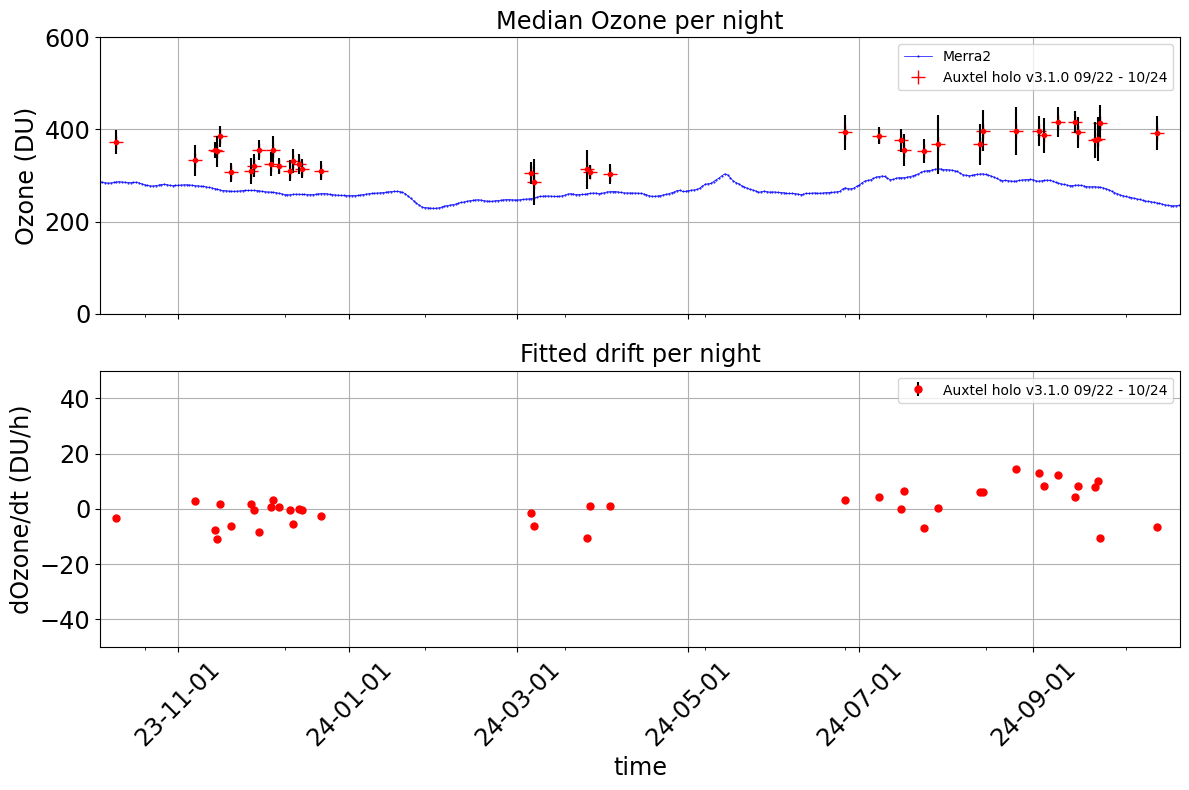

In [66]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(2,1,figsize=(12,8),sharex=True)
ax1,ax2  = axs

leg1=ax1.get_legend()
leg2=ax2.get_legend()

ax1.set_xlim(TMIN,TMAX)
df_m.plot(x="Time",y="TO3",ax=ax1,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df.plot(x="Time",y="median",ax=ax1,marker='+',c="r",lw=0.0,grid=True,ms=10,label=tag,legend=leg1)
ax1.errorbar(x=df["Time"], y=df["median"],yerr=df["std"],fmt=".",color="r",ecolor="k")

ax1.set_ylabel("Ozone (DU)")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title("Median Ozone per night")
ax1.set_ylim(0.,600.)
ax1.legend(loc="upper right")
ax1.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


ax2.set_title("Fitted drift per night")
ax2.errorbar(x=df["Time"], y=df["slope"],yerr=df["slope_err"],fmt=".",color="r",ecolor="k",ms=10,label=tag,legend=leg2)
ax2.grid()
ax2.set_ylabel("dOzone/dt (DU/h)")
ax2.set_xlabel("time")
ax2.set_ylim(-50.,50.)
ax2.xaxis.set_major_formatter(date_form)
ax2.legend(loc="upper right")

ax2.tick_params(axis='x', labelrotation=45)
ax2.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

plt.tight_layout()
figname =f"{pathfigs}/ozone_medianspredslope_allnights"+figtype
plt.savefig(figname)
plt.show()


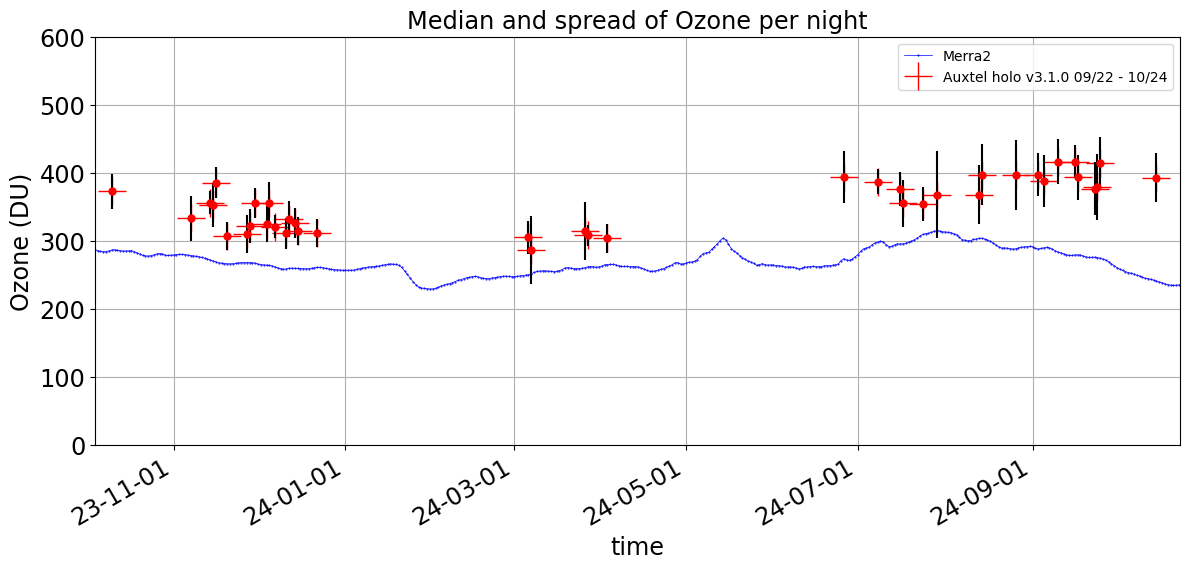

In [67]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX)
df_m.plot(x="Time",y="TO3",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df.plot(x="Time",y="median",ax=ax,marker='+',c="r",ms=20,lw=0.0,grid=True,label=tag,legend=leg)
ax.errorbar(x=df["Time"], y=df["median"],yerr=df["std"],fmt="o",ms=5,color="r",ecolor="k")
ax.set_ylabel("Ozone (DU)")
ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Median and spread of Ozone per night")
ax.set_ylim(0.,600)

ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)
ax.legend(loc="upper right")

figname =f"{pathfigs}/ozone_medians_allnights"+figtype
plt.savefig(figname)
plt.show()
